In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('BankChurners.csv')
df = df.iloc[:, :-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df["Attrition_Flag"] = df["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})
df["Income_Category_Numerical"] = df["Income_Category"].map({'Less than $40K': 40, '$60K - $80K':70, '$80K - $120K':100, '$120K +': 120, 'Unknown': 80})

In [4]:
df["Income_Category"].unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [5]:
df.shape

(10127, 22)

In [6]:
df.iloc[:, 1:].describe().T.style.bar(
    subset=['mean'],
    color='lightsalmon').background_gradient(
    subset=['std'], cmap='plasma').background_gradient(subset=['75%'], cmap='plasma').background_gradient(
    subset=['max'], cmap='plasma')

,count,mean,std,min,25%,50%,75%,max
Attrition_Flag,10127.000000,0.160660,0.367235,0.000000,0.000000,0.000000,0.000000,1.000000
Customer_Age,10127.000000,46.325960,8.016814,26.000000,41.000000,46.000000,52.000000,73.000000
Dependent_count,10127.000000,2.346203,1.298908,0.000000,1.000000,2.000000,3.000000,5.000000
Months_on_book,10127.000000,35.928409,7.986416,13.000000,31.000000,36.000000,40.000000,56.000000
Total_Relationship_Count,10127.000000,3.812580,1.554408,1.000000,3.000000,4.000000,5.000000,6.000000
Months_Inactive_12_mon,10127.000000,2.341167,1.010622,0.000000,2.000000,2.000000,3.000000,6.000000
Contacts_Count_12_mon,10127.000000,2.455317,1.106225,0.000000,2.000000,2.000000,3.000000,6.000000
Credit_Limit,10127.000000,8631.953698,9088.776650,1438.300000,2555.000000,4549.000000,11067.500000,34516.000000
Total_Revolving_Bal,10127.000000,1162.814061,814.987335,0.000000,359.000000,1276.000000,1784.000000,2517.000000
Avg_Open_To_Buy,10127.000000,7469.139637,9090.685324,3.000000,1324.500000,3474.000000,9859.000000,34516.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CLIENTNUM                  10127 non-null  int64  
 1   Attrition_Flag             10127 non-null  int64  
 2   Customer_Age               10127 non-null  int64  
 3   Gender                     10127 non-null  object 
 4   Dependent_count            10127 non-null  int64  
 5   Education_Level            10127 non-null  object 
 6   Marital_Status             10127 non-null  object 
 7   Income_Category            10127 non-null  object 
 8   Card_Category              10127 non-null  object 
 9   Months_on_book             10127 non-null  int64  
 10  Total_Relationship_Count   10127 non-null  int64  
 11  Months_Inactive_12_mon     10127 non-null  int64  
 12  Contacts_Count_12_mon      10127 non-null  int64  
 13  Credit_Limit               10127 non-null  flo

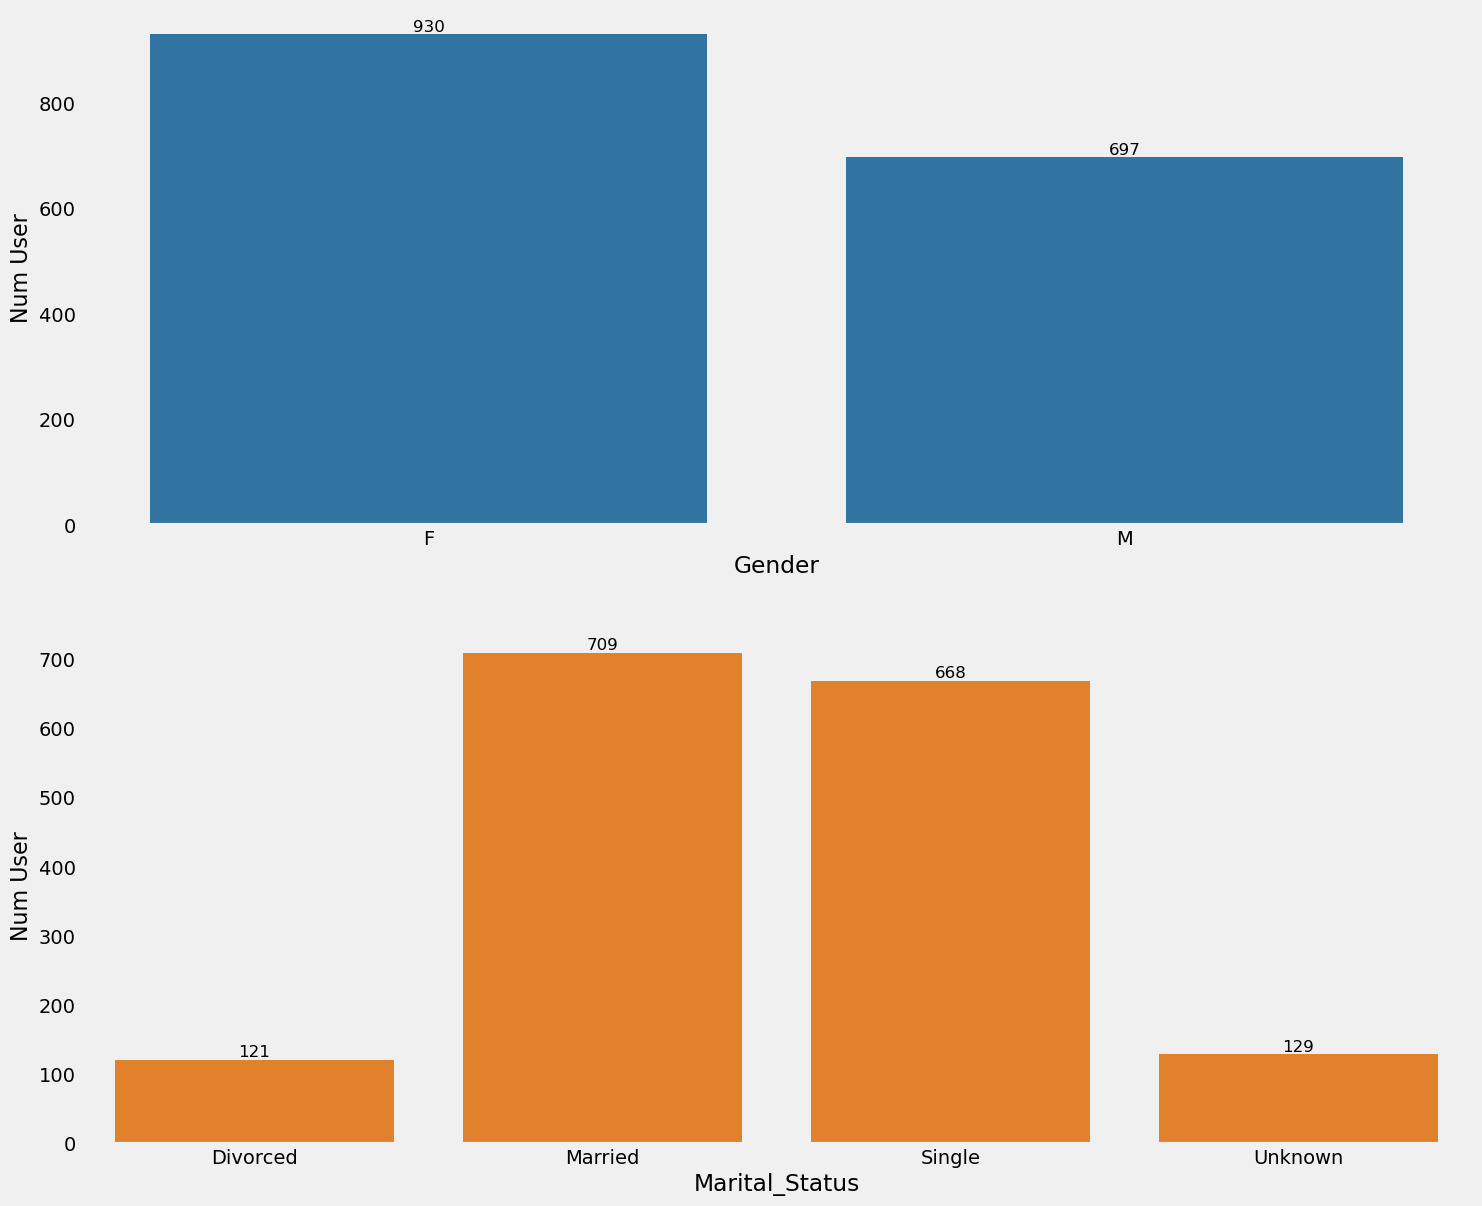

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 14))

i = 0 # counter

# List of colors for the bars
colors = ['#1f77b4', '#ff7f0e']

for cols, color in zip(['Gender', 'Marital_Status'], colors):
    df_group = df.loc[df.Attrition_Flag == 1].groupby(cols).agg(num_user=('CLIENTNUM', 'count')).reset_index()
    
    sns.barplot(x=df_group[cols], y=df_group['num_user'], ax=ax[i], color=color)
                
    ax[i].xaxis.set_tick_params(labelsize=14)
    ax[i].set_ylabel('Num User', fontsize=16)
    
    # Add labels to the bars
    for container in ax[i].containers:
        ax[i].bar_label(container, fontsize=12)
        
    ax[i].grid(False)
    i = i + 1

plt.show()


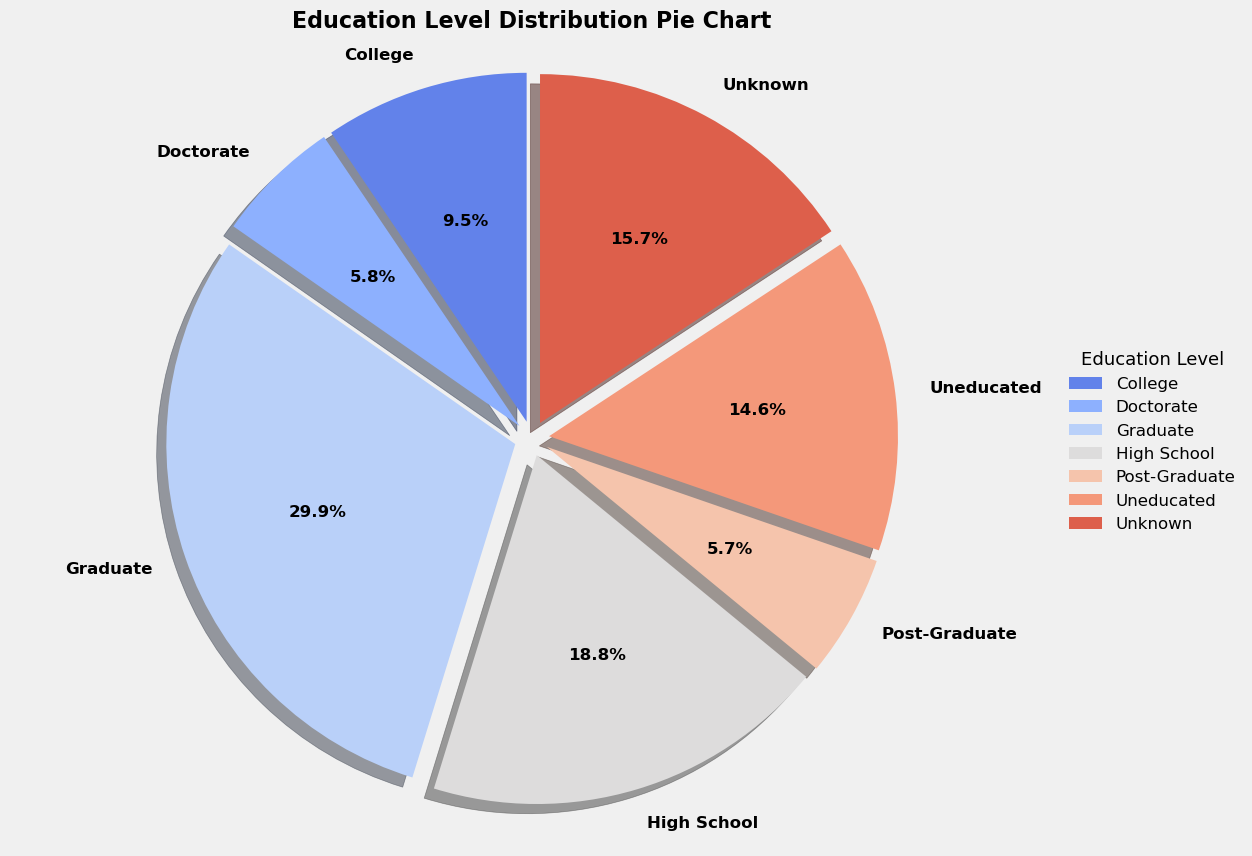

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and aggregate the data
df_group = df.loc[df.Attrition_Flag == 1].groupby(['Education_Level']).agg(num_user=('CLIENTNUM', 'count')).reset_index()

# Data for education levels
labels = df_group['Education_Level']
sizes = df_group['num_user']

# Define colors using a visually pleasing palette
colors = sns.color_palette("coolwarm", len(labels))

# Define an explode effect to highlight each segment
explode = [0.05] * len(labels)  # Adjust the explode value as needed

# Create a pie chart
plt.figure(figsize=(12, 10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        explode=explode, shadow=True, textprops={'fontsize': 12, 'weight': 'bold'})
plt.title('Education Level Distribution Pie Chart', fontsize=16, weight='bold')
plt.axis('equal')  # Ensure the pie chart is circular

# Add a legend outside the pie chart
plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title='Education Level', title_fontsize='13', frameon=False)

plt.show()


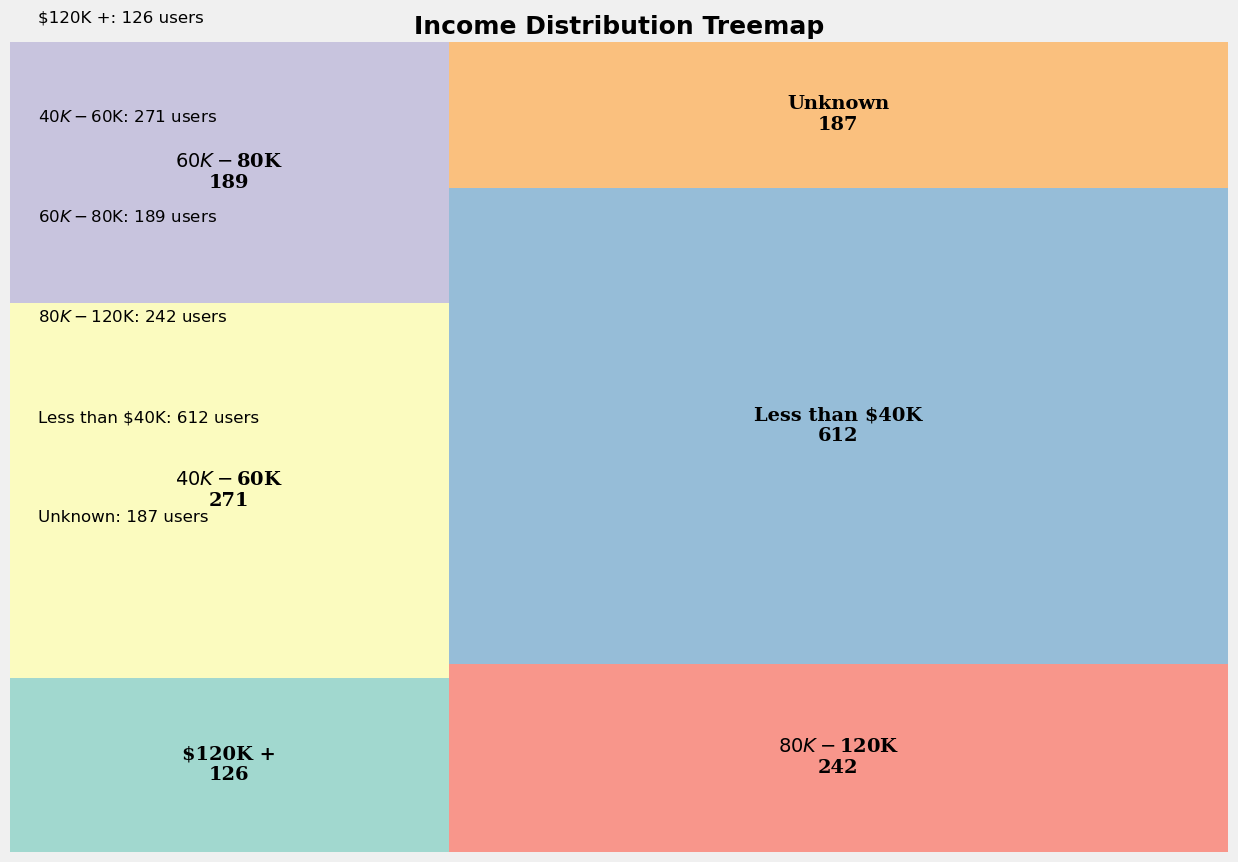

In [10]:
import matplotlib.pyplot as plt
import squarify

# Group and aggregate the data
df_group = df.loc[df.Attrition_Flag == 1].groupby(['Income_Category']).agg(num_user=('CLIENTNUM', 'count')).reset_index()

# Data for income categories
labels = df_group['Income_Category']
sizes = df_group['num_user']

# Define a color palette
colors = sns.color_palette("Set3", len(labels))

# Create labels that include both the category and the size
labels_with_sizes = [f'{label}\n{size}' for label, size in zip(labels, sizes)]

# Create the treemap
plt.figure(figsize=(14, 10))
squarify.plot(sizes=sizes, label=labels_with_sizes, color=colors, alpha=.8, text_kwargs={'fontsize':14, 'weight':'bold', 'fontfamily':'serif'})
plt.title('Income Distribution Treemap', fontsize=18, weight='bold')

# Add custom annotations or explanations
for i, (size, label) in enumerate(zip(sizes, labels)):
    plt.text(0.1, 0.9 - i*0.1, f'{label}: {size} users', fontsize=12, transform=plt.gcf().transFigure)

plt.axis('off')
plt.show()


  Marital_Status  Attrition_Flag  num_user
0       Divorced               0       627
1       Divorced               1       121
2        Married               0      3978
3        Married               1       709
4         Single               0      3275
5         Single               1       668
6        Unknown               0       620
7        Unknown               1       129


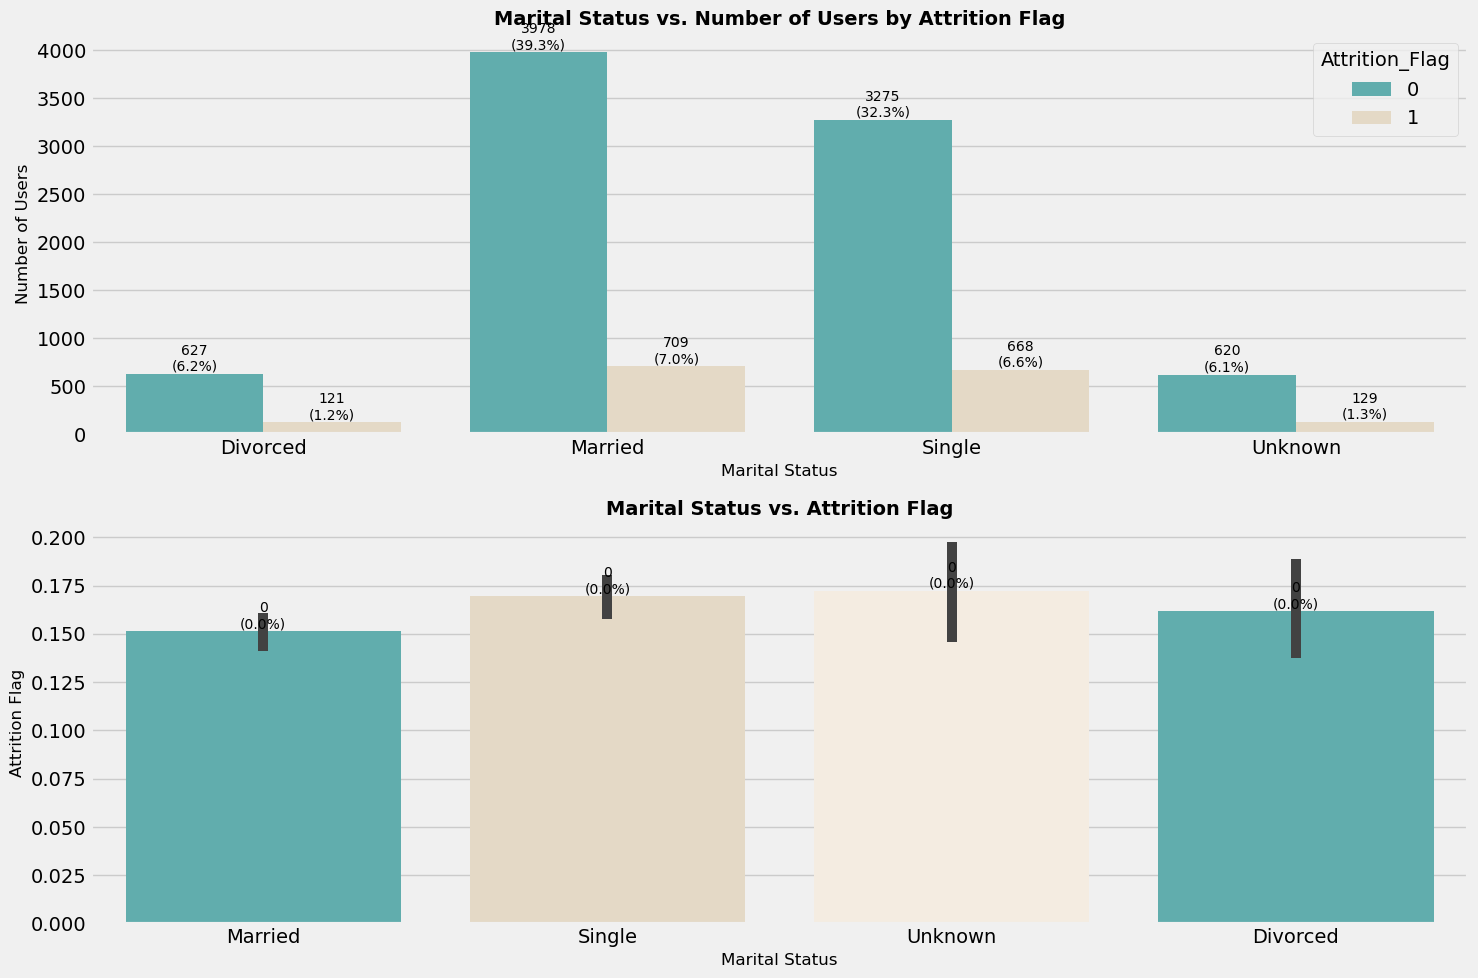

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15, 10))

# Group and aggregate the data
df_group = df.groupby(["Marital_Status", "Attrition_Flag"]).agg(num_user=('CLIENTNUM', 'count')).reset_index()

# Print the aggregated data
print(df_group)

# First bar plot
sns.barplot(data=df_group, x='Marital_Status', y='num_user', hue='Attrition_Flag', ax=ax[0], palette=('#54BAB9', '#E9DAC1', '#F7ECDE'))

# Add labels and percentages to the first bar plot
for container in ax[0].containers:
    labels = [f'{w:.0f}\n({w*100/df_group.num_user.sum():.1f}%)' for w in container.datavalues]
    ax[0].bar_label(container, labels=labels, label_type='edge', fontsize=10)

# Second bar plot
sns.barplot(x=df['Marital_Status'], y=df['Attrition_Flag'], ax=ax[1], palette=('#54BAB9', '#E9DAC1', '#F7ECDE'))

# Add labels and percentages to the second bar plot
total = len(df['Attrition_Flag'])
for container in ax[1].containers:
    labels = [f'{w:.0f}\n({w*100/total:.1f}%)' for w in container.datavalues]
    ax[1].bar_label(container, labels=labels, label_type='edge', fontsize=10)

# Customize plots
ax[0].set_title('Marital Status vs. Number of Users by Attrition Flag', fontsize=14, weight='bold')
ax[0].set_ylabel('Number of Users', fontsize=12)
ax[0].set_xlabel('Marital Status', fontsize=12)

ax[1].set_title('Marital Status vs. Attrition Flag', fontsize=14, weight='bold')
ax[1].set_ylabel('Attrition Flag', fontsize=12)
ax[1].set_xlabel('Marital Status', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [12]:
num_cols = list(df.select_dtypes(["int64","float64"]))
cat_cols = list(df.select_dtypes("object"))
cat_cols
['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

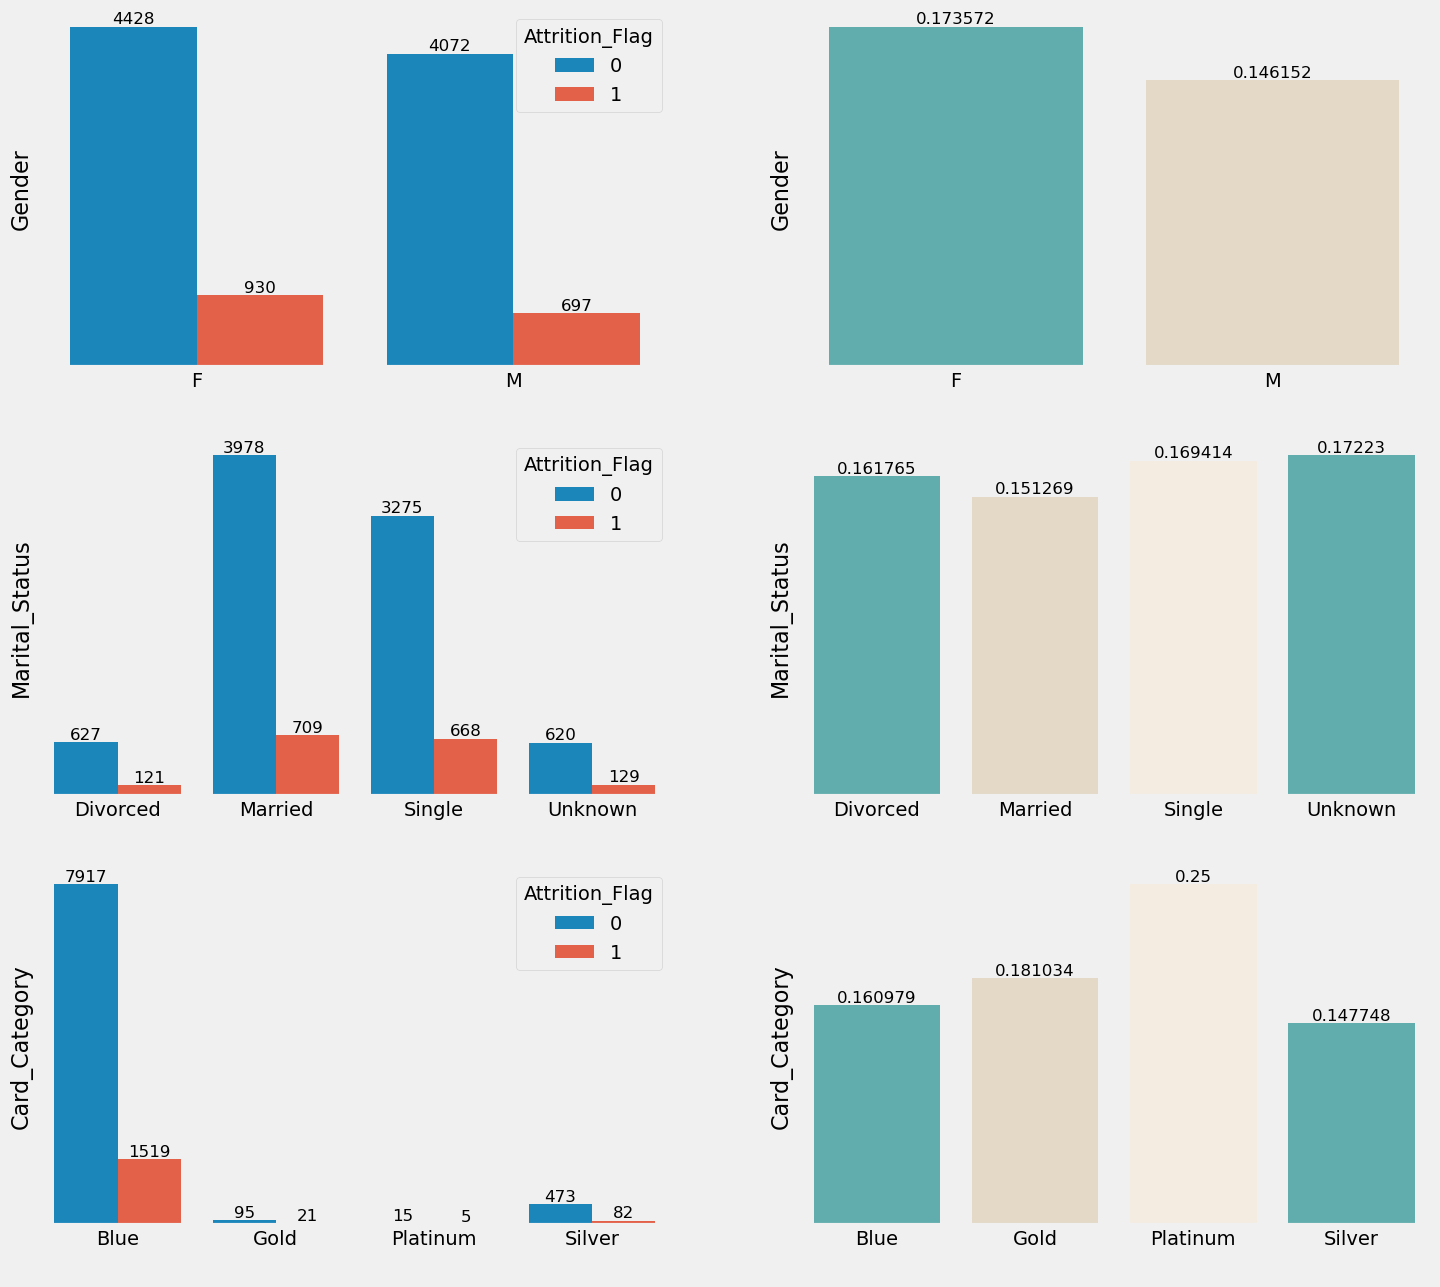

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 5*3))
                
i = 0 #counter

for cols in ['Gender',
 'Marital_Status',
 'Card_Category']:
    
    df_group_count = df.groupby([cols, "Attrition_Flag"]).agg(num_user=('CLIENTNUM', 'count')).reset_index()
    df_group_mean = df.groupby([cols]).agg(Attrition_Flag=('Attrition_Flag', 'mean')).reset_index()
#     print(df_group)

    sns.barplot(data=df_group_count, x=cols, y='num_user', hue='Attrition_Flag', ax=ax[i][0])

    sns.barplot(data=df_group_mean, x=cols, y='Attrition_Flag', fill=True, alpha=1, ci=None, ax=ax[i][1], palette=('#54BAB9', '#E9DAC1','#F7ECDE'))
                
    ax[i][0].set_xlabel(' ')
    ax[i][0].set_xlabel(' ')
    ax[i][0].set_ylabel(' ')
    ax[i][0].xaxis.set_tick_params(labelsize=14)
    ax[i][0].tick_params(left=False, labelleft=False)
    ax[i][0].set_ylabel(cols, fontsize=16)    
    ax[i][0].bar_label(ax[i][0].containers[0], size="12")
    ax[i][0].bar_label(ax[i][0].containers[1], size="12")
    ax[i][0].grid(False)
    
    ax[i][1].set_xlabel(' ')
    ax[i][1].set_xlabel(' ')
    ax[i][1].set_ylabel(' ')
    ax[i][1].xaxis.set_tick_params(labelsize=14)
    ax[i][1].tick_params(left=False, labelleft=False)
    ax[i][1].set_ylabel(cols, fontsize=16)    
    ax[i][1].bar_label(ax[i][1].containers[0], size="12")
    ax[i][1].grid(False)
    i=i+1
    
      
plt.show()

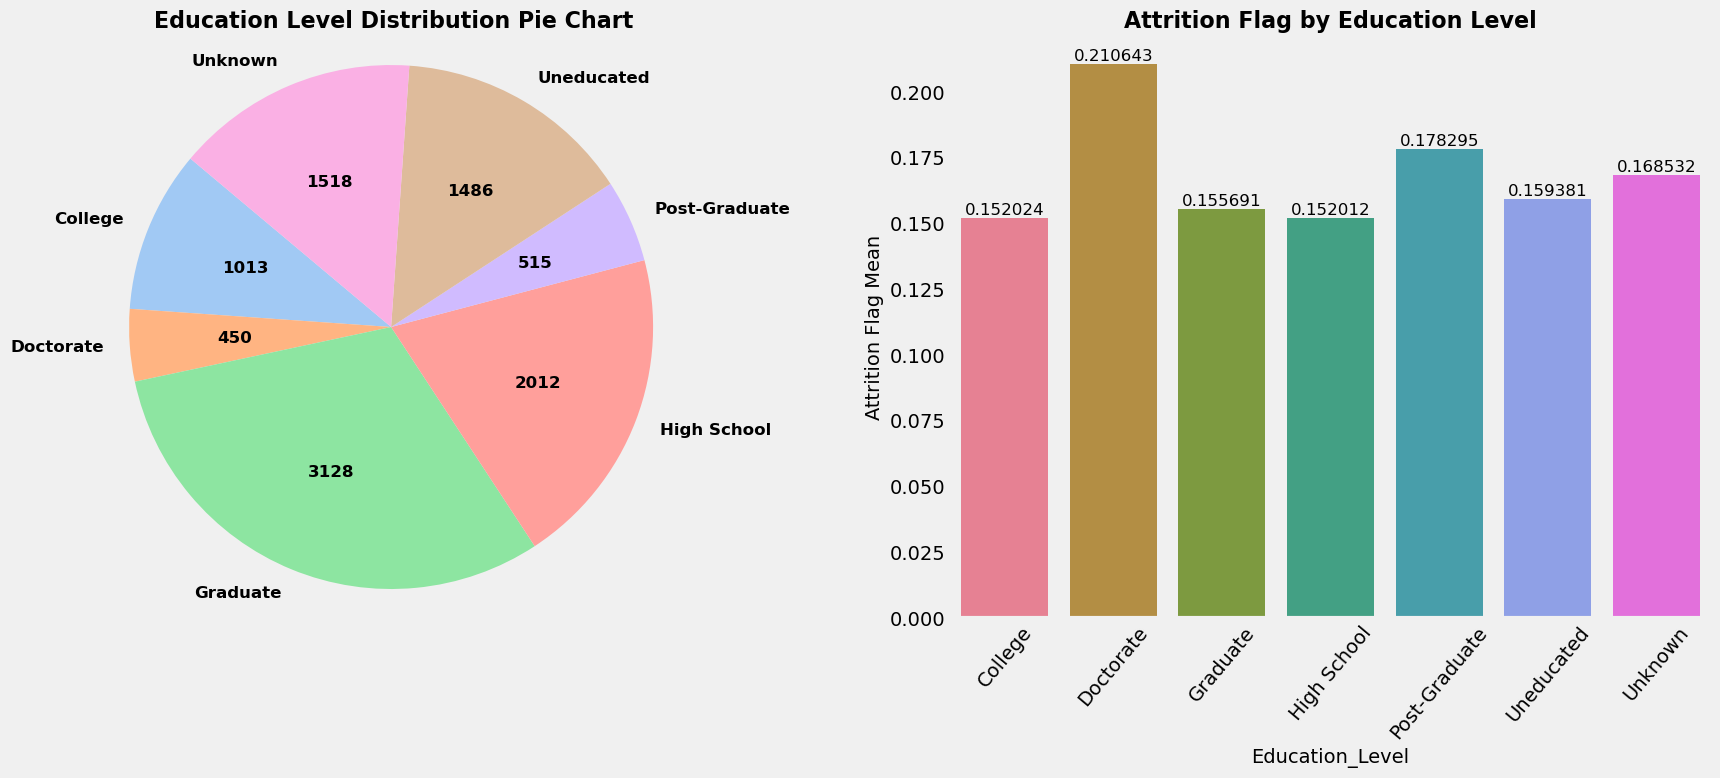

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate the data by Education_Level
cols = 'Education_Level'
df_group = df.groupby([cols]).agg(num_user=('CLIENTNUM', 'count')).reset_index()

# Data for the pie chart
labels = df_group[cols]
sizes = df_group['num_user']
colors = sns.color_palette("pastel", len(labels))

# Function to display absolute values on the pie chart
def absolute_value(val):
    a = int(val / 100. * sum(sizes))
    return f'{a}'

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Pie chart
ax[0].pie(sizes, labels=labels, colors=colors, autopct=absolute_value, startangle=140, textprops={'fontsize': 12, 'weight': 'bold'})
ax[0].set_title('Education Level Distribution Pie Chart', fontsize=16, weight='bold')
ax[0].axis('equal')  # Ensure the pie chart is circular

# Bar plot
df_group_mean = df.groupby([cols]).agg(Attrition_Flag=('Attrition_Flag', 'mean')).reset_index()
sns.barplot(data=df_group_mean, x=cols, y='Attrition_Flag', ax=ax[1], palette=sns.color_palette("husl", len(labels)))

# Customize the bar plot
ax[1].set_title('Attrition Flag by Education Level', fontsize=16, weight='bold')
ax[1].set_ylabel('Attrition Flag Mean', fontsize=14)
ax[1].set_xlabel(cols, fontsize=14)
ax[1].bar_label(ax[1].containers[0], size="12")
ax[1].set_xticklabels(labels, rotation=50)
ax[1].grid(False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


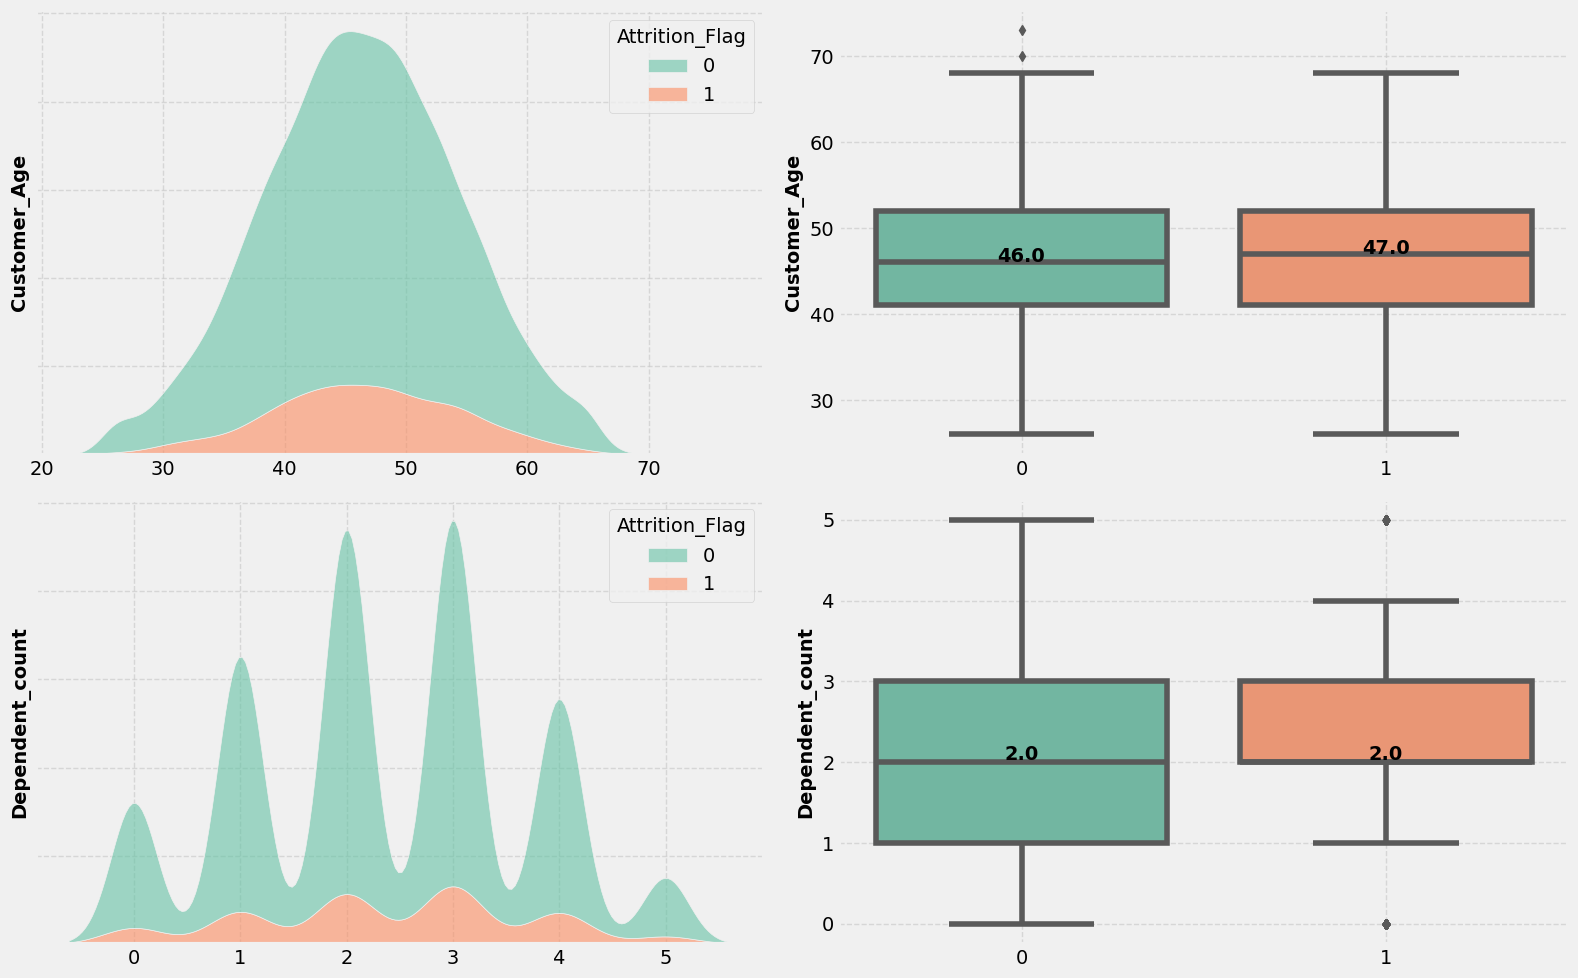

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the columns to visualize
cols_visua = [
    'Customer_Age',
    'Dependent_count',
]

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=len(cols_visua), figsize=(16, 5*len(cols_visua)))

# Counter
i = 0

for cols in cols_visua:
    # KDE plot
    sns.kdeplot(df[cols], fill=True, alpha=0.6, hue=df['Attrition_Flag'],
                palette=sns.color_palette("Set2", 2), multiple='stack', ax=ax[i, 0])
    
    # Box plot
    sns.boxplot(data=df, y=cols, x='Attrition_Flag', ax=ax[i, 1],
                palette=sns.color_palette("Set2", 2), color='white')
    
    # Customize the KDE plot
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel(cols, fontsize=14, weight='bold')
    ax[i, 0].tick_params(left=False, labelleft=False)
    ax[i, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Add data labels to the KDE plot
    for line in ax[i, 0].get_lines():
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for j in range(len(x_data)):
            if j % 20 == 0:  # Annotate every 20th data point
                ax[i, 0].annotate(f'{int(y_data[j])}', xy=(x_data[j], y_data[j]), fontsize=9, ha='center')
    
    # Customize the Box plot
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('')
    ax[i, 1].xaxis.set_tick_params(labelsize=14)
    ax[i, 1].grid(True, linestyle='--', alpha=0.7)
    ax[i, 1].set_ylabel(cols, fontsize=14, weight='bold')
    
    # Add data labels to the box plot
    medians = df.groupby('Attrition_Flag')[cols].median()
    for tick, label in zip(range(len(medians)), ax[i, 1].get_xticklabels()):
        ax[i, 1].text(tick, medians[tick] + 0.03, round(medians[tick], 2), 
                      horizontalalignment='center', size='medium', color='black', weight='semibold')
    
    # Increase the counter
    i += 1

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()



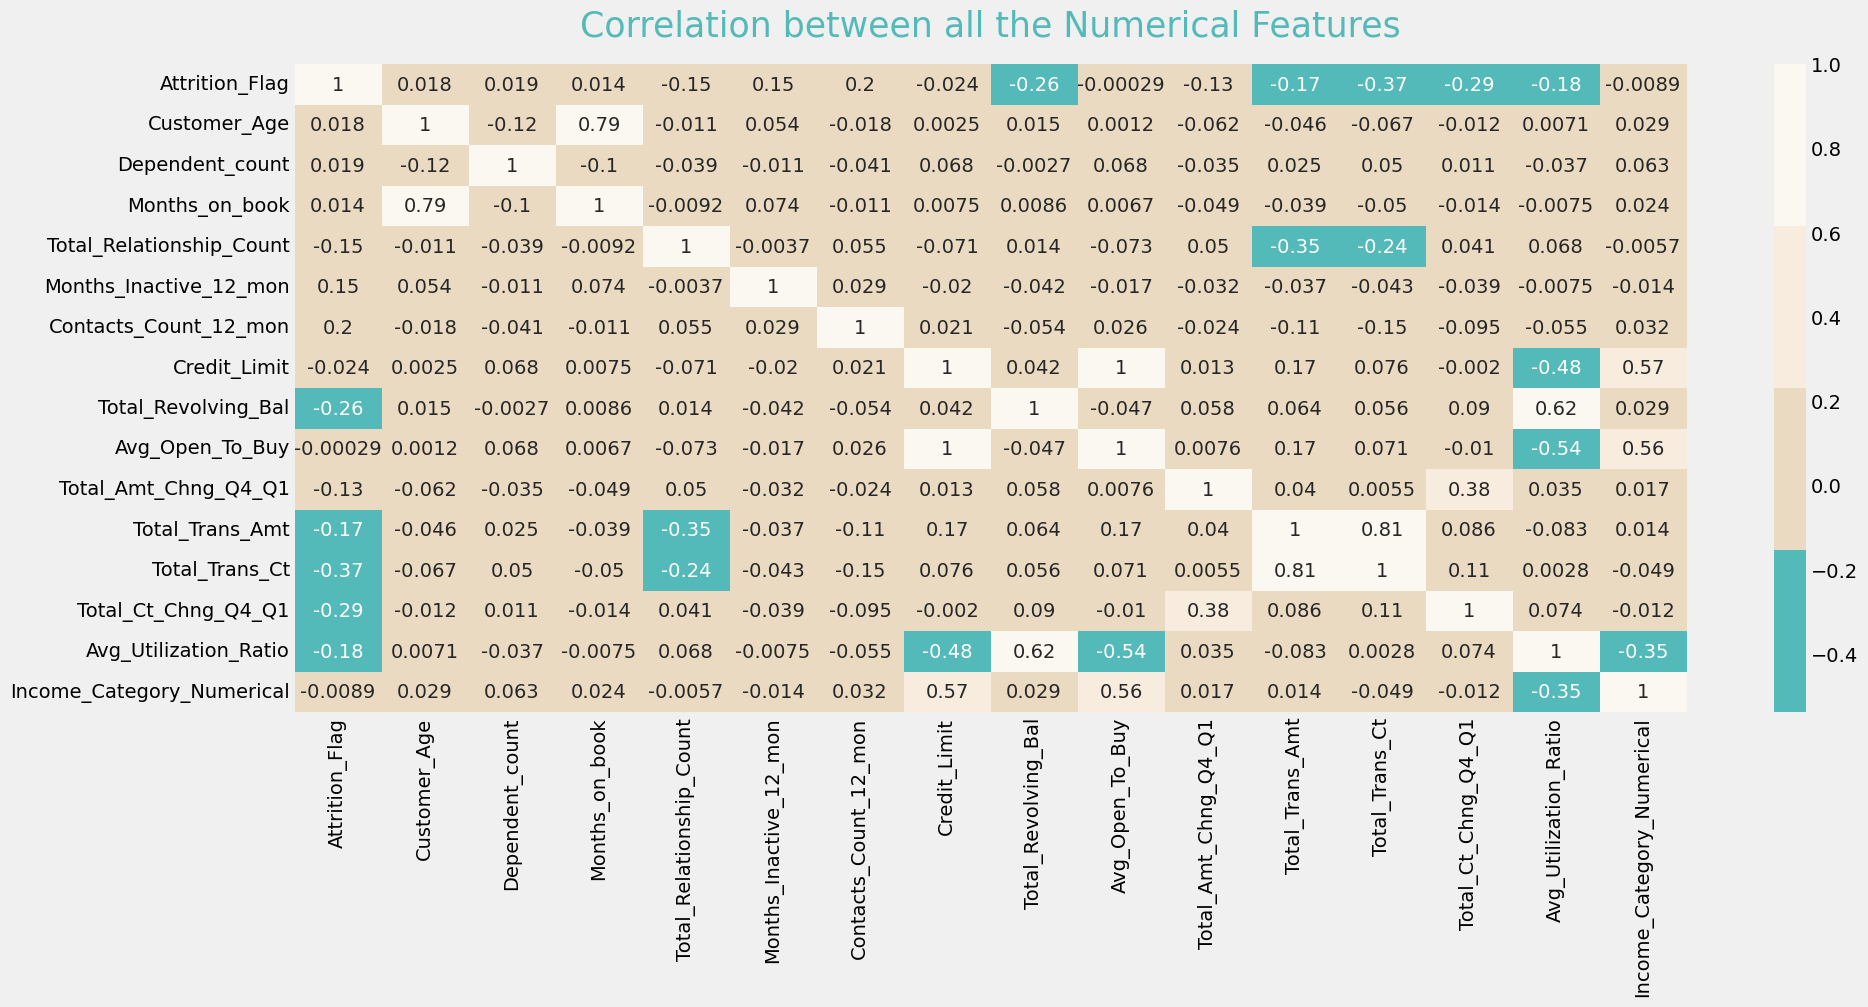

In [16]:
heat = df.iloc[:, 1:].corr()
plt.figure(figsize=[20,8])
plt.title("Correlation between all the Numerical Features", size=25, pad=20, color='#54BAB9')
sns.heatmap(heat, cmap=['#54BAB9', '#E9DAC1','#F7ECDE','#FBF8F1'], annot=True)
plt.show()

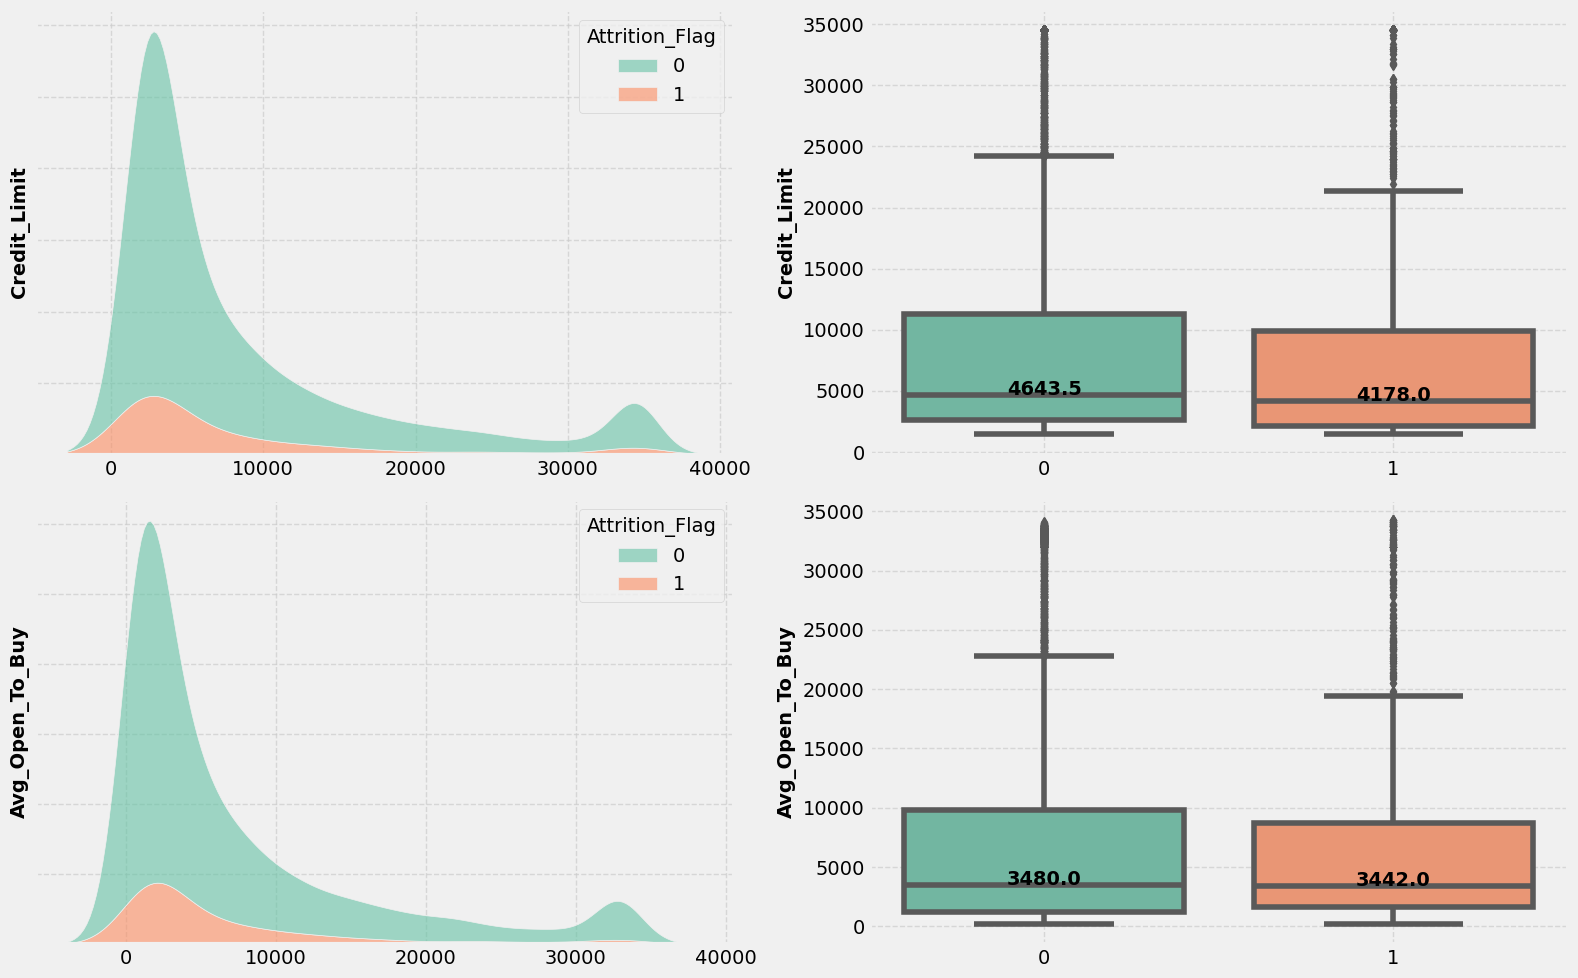

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to visualize
cols_visua = [
    'Credit_Limit',
    'Avg_Open_To_Buy',
]

# Create a copy of the dataframe to avoid modifying the original
df_visual = df.copy()

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=len(cols_visua), figsize=(16, 5*len(cols_visua)))

# Counter
i = 0

for cols in cols_visua:
    # Removing outliers
    Q3 = df_visual[cols].quantile(0.99)
    Q1 = df_visual[cols].quantile(0.01)
    df_filtered = df_visual[(df_visual[cols] <= Q3) & (df_visual[cols] >= Q1)]

    # KDE plot
    sns.kdeplot(df_filtered[cols], fill=True, alpha=0.6, hue=df_filtered['Attrition_Flag'],
                palette=sns.color_palette("Set2", 2), multiple='stack', ax=ax[i, 0])
    
    # Box plot
    sns.boxplot(data=df_filtered, y=cols, x='Attrition_Flag', ax=ax[i, 1],
                palette=sns.color_palette("Set2", 2), color='white')
    
    # Customize the KDE plot
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel(cols, fontsize=14, weight='bold')
    ax[i, 0].tick_params(left=False, labelleft=False)
    ax[i, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Add data labels to the KDE plot
    for line in ax[i, 0].get_lines():
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for j in range(len(x_data)):
            if j % 20 == 0:  # Annotate every 20th data point
                ax[i, 0].annotate(f'{int(y_data[j])}', xy=(x_data[j], y_data[j]), fontsize=9, ha='center')
    
    # Customize the Box plot
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('')
    ax[i, 1].xaxis.set_tick_params(labelsize=14)
    ax[i, 1].grid(True, linestyle='--', alpha=0.7)
    ax[i, 1].set_ylabel(cols, fontsize=14, weight='bold')
    
    # Add data labels to the box plot
    medians = df_filtered.groupby('Attrition_Flag')[cols].median()
    for tick, label in zip(range(len(medians)), ax[i, 1].get_xticklabels()):
        ax[i, 1].text(tick, medians[tick] + 0.03, round(medians[tick], 2), 
                      horizontalalignment='center', size='medium', color='black', weight='semibold')
    
    # Increase the counter
    i += 1

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [18]:
df.groupby(['Total_Relationship_Count']).agg(Attrition_Flag=('Attrition_Flag', 'mean')).reset_index()

,Total_Relationship_Count,Attrition_Flag
0,1,0.256044
1,2,0.278359
2,3,0.173536
3,4,0.117678
4,5,0.120042
5,6,0.105038


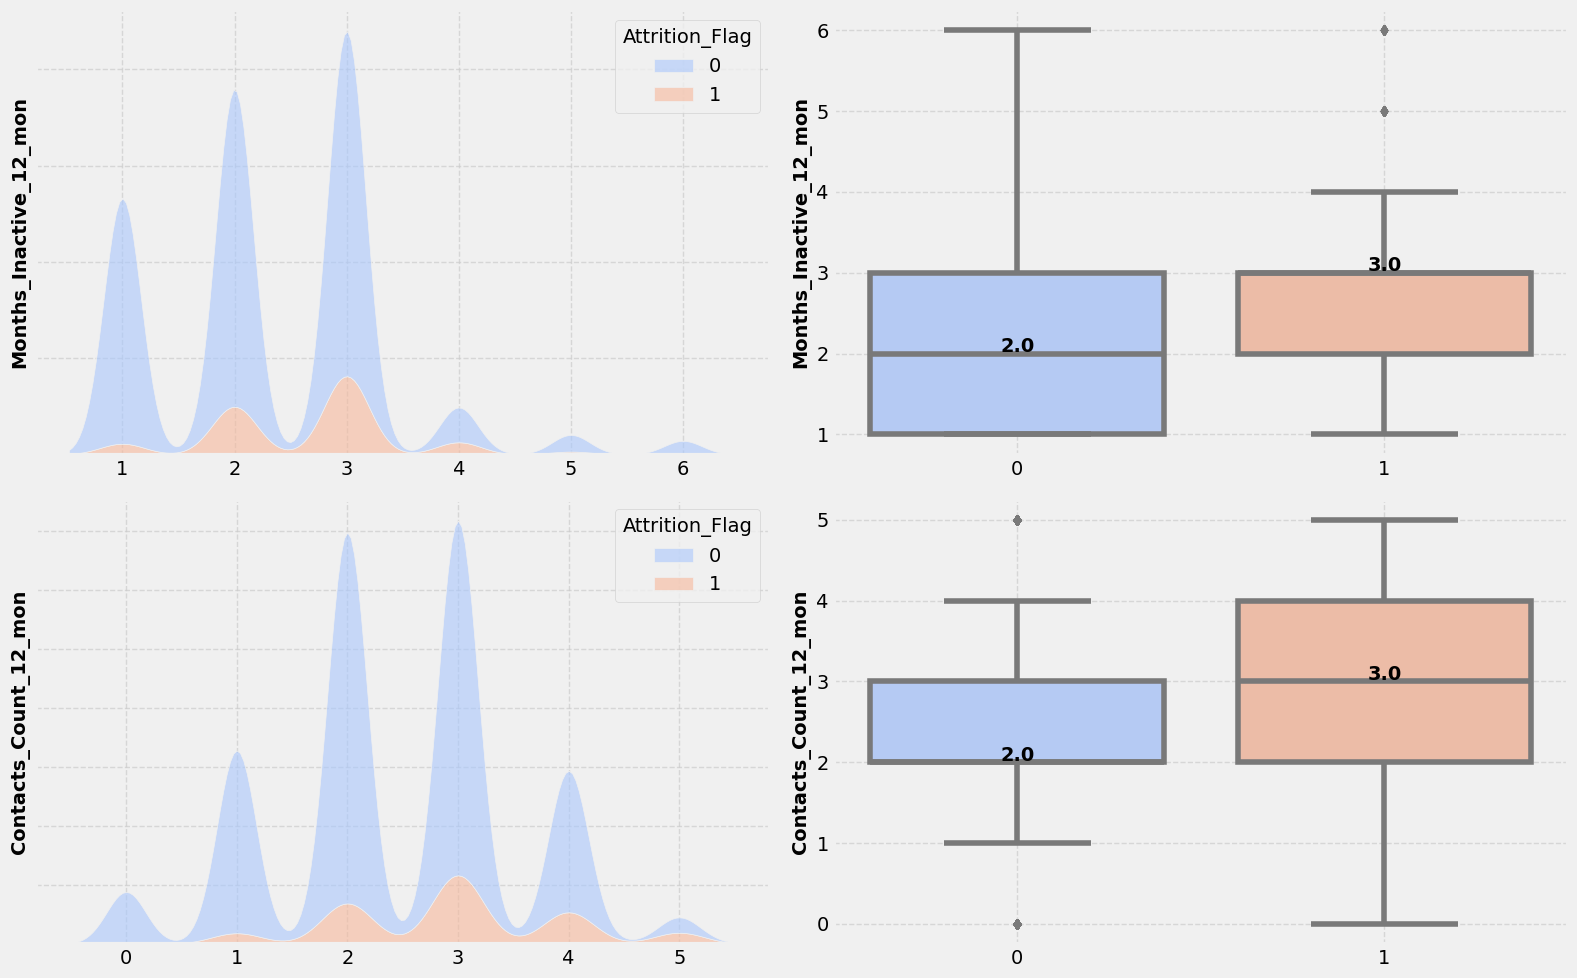

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to visualize
cols_visua = [
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
]

# Create a copy of the dataframe to avoid modifying the original
df_visual = df.copy()

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=len(cols_visua), figsize=(16, 5*len(cols_visua)))

# Counter
i = 0

for cols in cols_visua:
    # Removing outliers by clipping
    Q3 = df_visual[cols].quantile(0.99)
    Q1 = df_visual[cols].quantile(0.01)
    df_visual[cols] = df_visual[cols].clip(Q1, Q3)
    
    # KDE plot
    sns.kdeplot(df_visual[cols], fill=True, alpha=0.6, hue=df_visual['Attrition_Flag'],
                palette=sns.color_palette("coolwarm", 2), multiple='stack', ax=ax[i, 0])
    
    # Box plot
    sns.boxplot(data=df_visual, y=cols, x='Attrition_Flag', ax=ax[i, 1],
                palette=sns.color_palette("coolwarm", 2), color='white')
    
    # Customize the KDE plot
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel(cols, fontsize=14, weight='bold')
    ax[i, 0].tick_params(left=False, labelleft=False)
    ax[i, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Add data labels to the KDE plot
    for line in ax[i, 0].get_lines():
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for j in range(len(x_data)):
            if j % 20 == 0:  # Annotate every 20th data point
                ax[i, 0].annotate(f'{int(y_data[j])}', xy=(x_data[j], y_data[j]), fontsize=9, ha='center')
    
    # Customize the Box plot
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('')
    ax[i, 1].xaxis.set_tick_params(labelsize=14)
    ax[i, 1].grid(True, linestyle='--', alpha=0.7)
    ax[i, 1].set_ylabel(cols, fontsize=14, weight='bold')
    
    # Add data labels to the box plot
    medians = df_visual.groupby('Attrition_Flag')[cols].median()
    for tick, label in zip(range(len(medians)), ax[i, 1].get_xticklabels()):
        ax[i, 1].text(tick, medians[tick] + 0.02, round(medians[tick], 2), 
                      horizontalalignment='center', size='medium', color='black', weight='semibold')
    
    # Increase the counter
    i += 1

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [20]:
df_large_amount = df.groupby("Months_Inactive_12_mon").agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

df_large_amount["Churn_rate"] = df_large_amount['num_churn']/df_large_amount["num_user"]
df_large_amount

,num_user,num_churn,Churn_rate
Months_Inactive_12_mon,,,
0,29,15,0.517241
1,2233,100,0.044783
2,3282,505,0.153870
3,3846,826,0.214769
4,435,130,0.298851
5,178,32,0.179775
6,124,19,0.153226


In [21]:
df_large_amount = df.groupby("Contacts_Count_12_mon").agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

df_large_amount["Churn_rate"] = df_large_amount['num_churn']/df_large_amount["num_user"]
df_large_amount

,num_user,num_churn,Churn_rate
Contacts_Count_12_mon,,,
0,399,7,0.017544
1,1499,108,0.072048
2,3227,403,0.124884
3,3380,681,0.201479
4,1392,315,0.226293
5,176,59,0.335227
6,54,54,1.000000


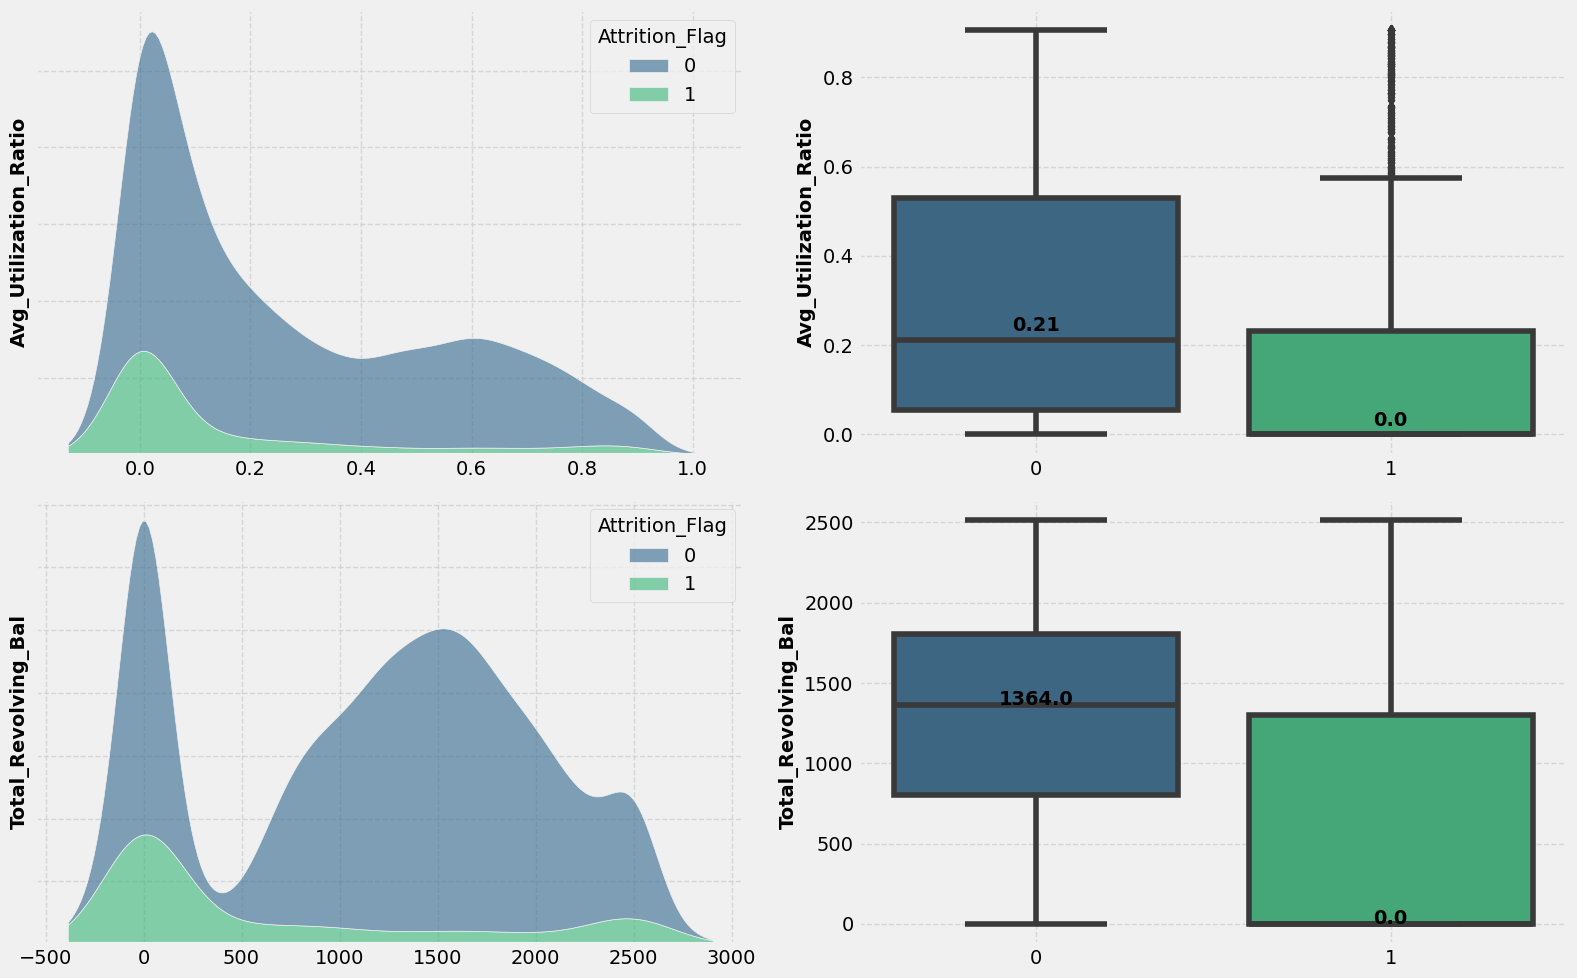

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to visualize
cols_visua = [
    'Avg_Utilization_Ratio',
    'Total_Revolving_Bal',
]

# Create a copy of the dataframe to avoid modifying the original
df_visual = df.copy()

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=len(cols_visua), figsize=(16, 5*len(cols_visua)))

# Counter
i = 0

for cols in cols_visua:
    # Removing outliers by clipping
    Q3 = df_visual[cols].quantile(0.99)
    Q1 = df_visual[cols].quantile(0.01)
    df_visual[cols] = df_visual[cols].clip(Q1, Q3)
    
    # KDE plot
    sns.kdeplot(df_visual[cols], fill=True, alpha=0.6, hue=df_visual['Attrition_Flag'],
                palette=sns.color_palette("viridis", 2), multiple='stack', ax=ax[i, 0])
    
    # Box plot
    sns.boxplot(data=df_visual, y=cols, x='Attrition_Flag', ax=ax[i, 1],
                palette=sns.color_palette("viridis", 2), color='white')
    
    # Customize the KDE plot
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel(cols, fontsize=14, weight='bold')
    ax[i, 0].tick_params(left=False, labelleft=False)
    ax[i, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Add data labels to the KDE plot
    for line in ax[i, 0].get_lines():
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for j in range(0, len(x_data), max(1, len(x_data) // 10)):  # Annotate evenly spaced points
            ax[i, 0].annotate(f'{y_data[j]:.2f}', xy=(x_data[j], y_data[j]), fontsize=9, ha='center')

    # Customize the Box plot
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('')
    ax[i, 1].xaxis.set_tick_params(labelsize=14)
    ax[i, 1].grid(True, linestyle='--', alpha=0.7)
    ax[i, 1].set_ylabel(cols, fontsize=14, weight='bold')
    
    # Add data labels to the box plot
    medians = df_visual.groupby('Attrition_Flag')[cols].median()
    for tick, label in zip(range(len(medians)), ax[i, 1].get_xticklabels()):
        ax[i, 1].text(tick, medians[tick] + 0.02, round(medians[tick], 2), 
                      horizontalalignment='center', size='medium', color='black', weight='semibold')
    
    # Increase the counter
    i += 1

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [23]:
print(df.groupby(['Months_Inactive_12_mon']).agg(
    Churn_rate=('Attrition_Flag', 'mean'),
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
).reset_index())


print(df.groupby(['Contacts_Count_12_mon']).agg(
    Churn_rate=('Attrition_Flag', 'mean'),
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
).reset_index())

   Months_Inactive_12_mon  Churn_rate  num_user  num_churn
0                       0    0.517241        29         15
1                       1    0.044783      2233        100
2                       2    0.153870      3282        505
3                       3    0.214769      3846        826
4                       4    0.298851       435        130
5                       5    0.179775       178         32
6                       6    0.153226       124         19
   Contacts_Count_12_mon  Churn_rate  num_user  num_churn
0                      0    0.017544       399          7
1                      1    0.072048      1499        108
2                      2    0.124884      3227        403
3                      3    0.201479      3380        681
4                      4    0.226293      1392        315
5                      5    0.335227       176         59
6                      6    1.000000        54         54


In [24]:
print(df.groupby(['Months_Inactive_12_mon']).agg(
    Churn_rate=('Attrition_Flag', 'mean'),
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
).reset_index())


print(df.groupby(['Contacts_Count_12_mon']).agg(
    Churn_rate=('Attrition_Flag', 'mean'),
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
).reset_index())

   Months_Inactive_12_mon  Churn_rate  num_user  num_churn
0                       0    0.517241        29         15
1                       1    0.044783      2233        100
2                       2    0.153870      3282        505
3                       3    0.214769      3846        826
4                       4    0.298851       435        130
5                       5    0.179775       178         32
6                       6    0.153226       124         19
   Contacts_Count_12_mon  Churn_rate  num_user  num_churn
0                      0    0.017544       399          7
1                      1    0.072048      1499        108
2                      2    0.124884      3227        403
3                      3    0.201479      3380        681
4                      4    0.226293      1392        315
5                      5    0.335227       176         59
6                      6    1.000000        54         54


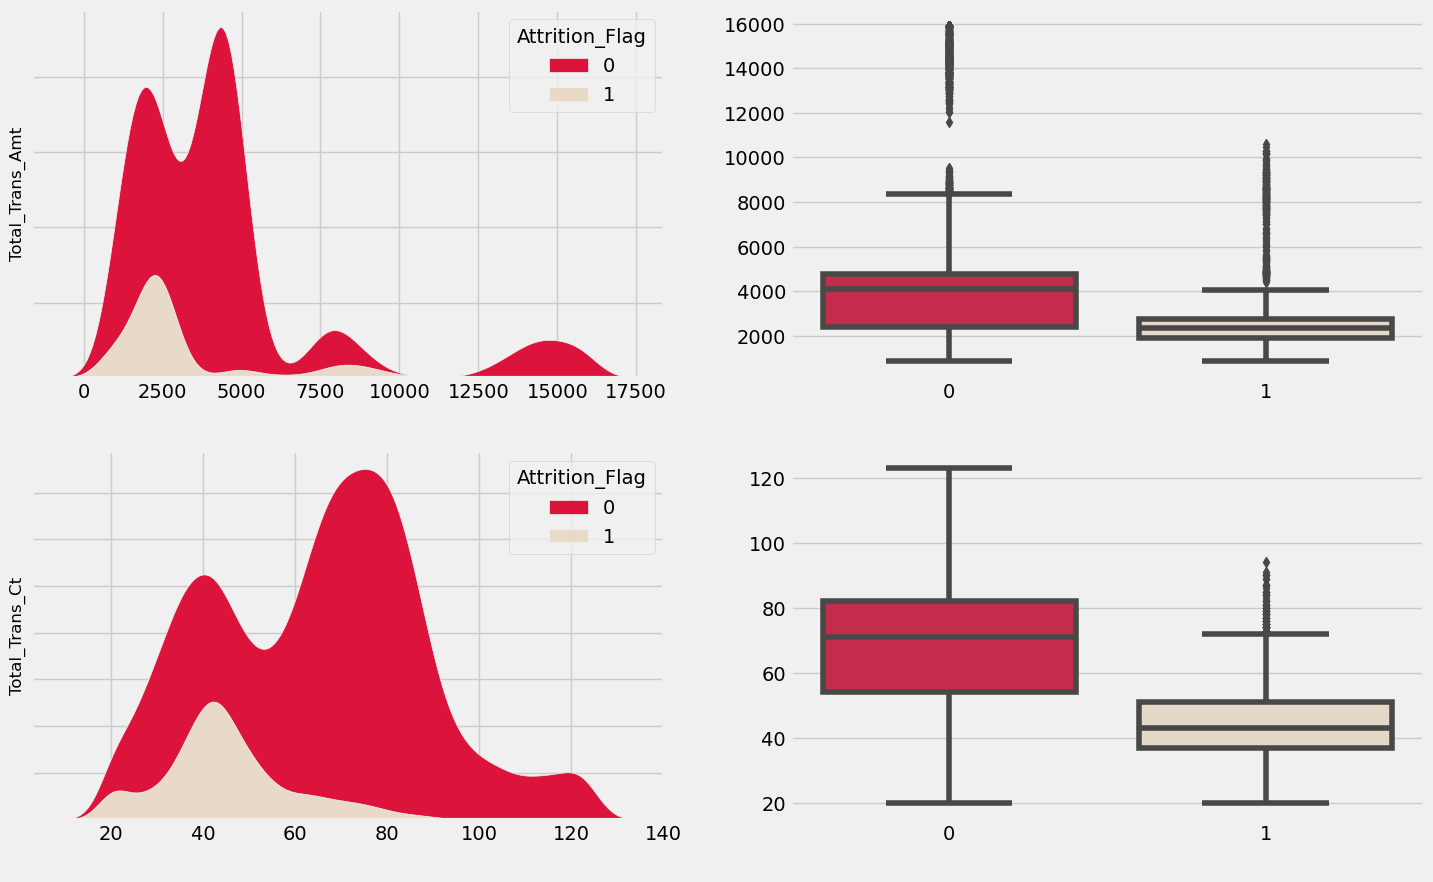

In [25]:
cols_visua = [
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    
]

fig, ax = plt.subplots(ncols=2, nrows=len(cols_visua), figsize=(16, 5*len(cols_visua)))

df_visual = df.copy()
                
i = 0 #counter
for cols in cols_visua:
    
    # Removing Outliers     
    Q3 = df[cols].quantile(0.99)
#     df = df[df[cols] <= Q3]
    Q1 = df[cols].quantile(0.01)
    df_visual.loc[:, cols] = df_visual[cols].clip(Q1, Q3)
    
    sns.kdeplot(df_visual[cols], fill=True, alpha=1, hue = df_visual['Attrition_Flag'], 
                palette=('#DC143C', '#E9DAC7'), multiple='stack', ax=ax[i,0])
    
    sns.boxplot(data= df_visual, y=cols, x='Attrition_Flag', ax=ax[i, 1],
               palette=('#DC143C', '#E9DAC1'), color='white')
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    ax[i,0].tick_params(left=False, labelleft=False)
    ax[i,0].set_ylabel(cols, fontsize=12)
    i=i+1
      
plt.show()

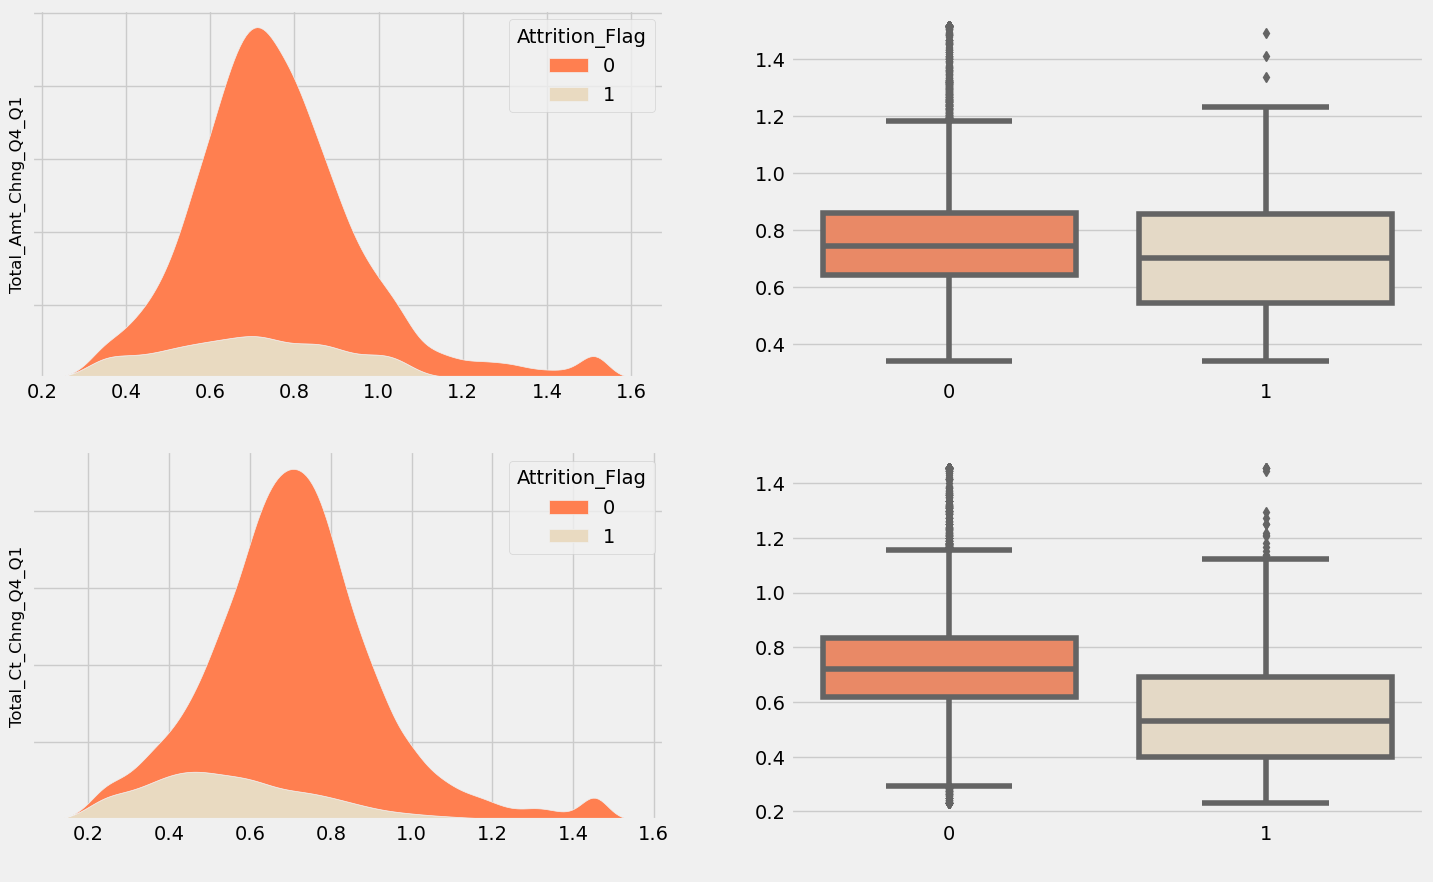

In [26]:
cols_visua = [
    'Total_Amt_Chng_Q4_Q1',

    'Total_Ct_Chng_Q4_Q1',
    
]

fig, ax = plt.subplots(ncols=2, nrows=len(cols_visua), figsize=(16, 5*len(cols_visua)))

df_visual = df.copy()
                
i = 0 #counter
for cols in cols_visua:
    
    # Removing Outliers     
    Q3 = df[cols].quantile(0.99)
#     df = df[df[cols] <= Q3]
    Q1 = df[cols].quantile(0.01)
    df_visual.loc[:, cols] = df_visual[cols].clip(Q1, Q3)
    
    sns.kdeplot(df_visual[cols], fill=True, alpha=1, hue = df_visual['Attrition_Flag'], 
                palette=('#FF7F50', '#E9DAC1'), multiple='stack', ax=ax[i,0])
    
    sns.boxplot(data= df_visual, y=cols, x='Attrition_Flag', ax=ax[i, 1],
               palette=('#FF7F50', '#E9DAC1'), color='white')
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    ax[i,0].tick_params(left=False, labelleft=False)
    ax[i,0].set_ylabel(cols, fontsize=12)
    i=i+1
      
plt.show()

In [27]:
df_user_inactive_and_contact = df.loc[
    (df.Months_Inactive_12_mon >= 2) & (df.Contacts_Count_12_mon >= 2)
].groupby(["Months_Inactive_12_mon", "Contacts_Count_12_mon"]).agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

df_user_inactive_and_contact["Churn rate"] = df_user_inactive_and_contact["num_churn"]/df_user_inactive_and_contact["num_user"]

print(df_user_inactive_and_contact.sum())
print("Churn rate: ", df_user_inactive_and_contact.num_churn.sum()/df_user_inactive_and_contact.num_user.sum())

df_user_inactive_and_contact

num_user      6438.000000
num_churn     1403.000000
Churn rate      11.279601
dtype: float64
Churn rate:  0.21792482137309724


num_user  num_churn  Churn rate
Months_Inactive_12_mon Contacts_Count_12_mon                                 
2                      2                          1064        131    0.123120
                       3                          1085        212    0.195392
                       4                           461        100    0.216920
                       5                            59         13    0.220339
                       6                            17         17    1.000000
3                      2                          1221        209    0.171171
                       3                          1288        328    0.254658
                       4                           546        162    0.296703
                       5                            73         31    0.424658
                       6                            30         30    1.000000
4                      2                           129         25    0.193798
                       3                           161         67    0.416149
                       4                            57         23    0.403509
                       5                             8          5    0.625000
                       6                             3          3    1.000000
5                      2                            56          5    0.089286
                       3                            61         13    0.213115
                       4                            21          7    0.333333
                       5                             3          3    1.000000
                       6                             1          1    1.000000
6                      2                            29          5    0.172414
                       3                            44          9    0.204545
                       4                            17          1    0.058824
                       5                             3          2    0.666667
                       6                             1          1    1.000000

In [28]:
df_user_inactive_and_less_trans = df.loc[(df.Months_Inactive_12_mon >= 2) & (df.Total_Trans_Ct <= 60)].groupby(["Months_Inactive_12_mon", "Contacts_Count_12_mon"]).agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

print(df_user_inactive_and_less_trans.sum())
print("Churn rate: ", df_user_inactive_and_less_trans.num_churn.sum()/df_user_inactive_and_less_trans.num_user.sum())


num_user     3253
num_churn    1298
dtype: int64
Churn rate:  0.39901629265293576


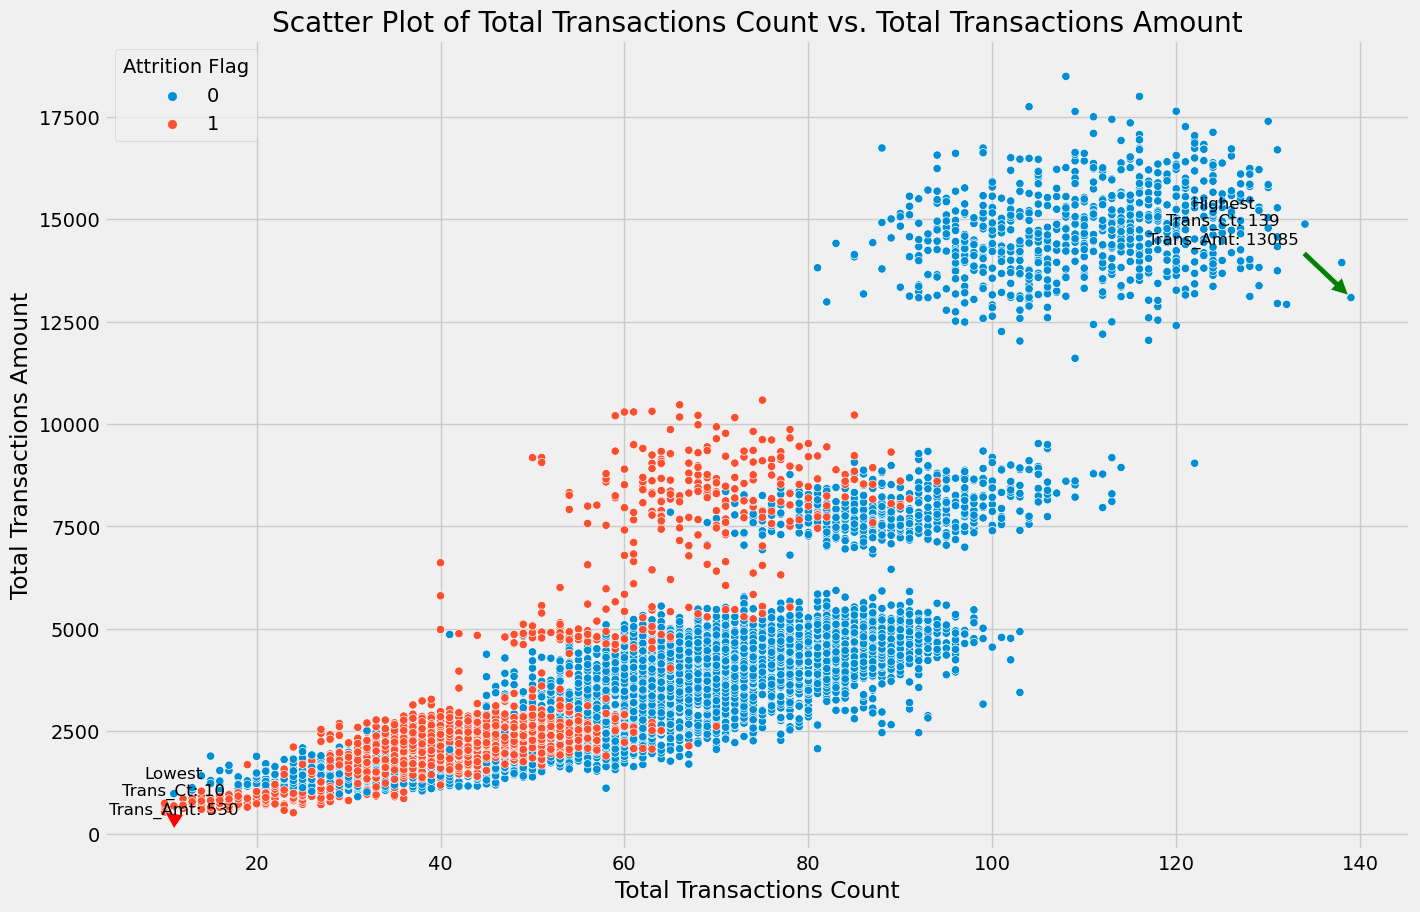

Highest Point Summary:
Total_Trans_Ct       139
Total_Trans_Amt    13085
Attrition_Flag         0
Name: 9324, dtype: object

Lowest Point Summary:
Total_Trans_Ct      10
Total_Trans_Amt    530
Attrition_Flag       1
Name: 144, dtype: object


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axis
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 10))

# Scatter plot
sns.scatterplot(data=df, x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Attrition_Flag', ax=ax)

# Find the highest and lowest points
max_point = df.loc[df[['Total_Trans_Ct', 'Total_Trans_Amt']].idxmax()]
min_point = df.loc[df[['Total_Trans_Ct', 'Total_Trans_Amt']].idxmin()]

# Ensure selecting a single row for annotation
if isinstance(max_point, pd.DataFrame):
    max_point = max_point.iloc[0]
if isinstance(min_point, pd.DataFrame):
    min_point = min_point.iloc[0]

# Annotate the highest point
ax.annotate(f'Highest\nTrans_Ct: {max_point["Total_Trans_Ct"]}\nTrans_Amt: {max_point["Total_Trans_Amt"]}',
            xy=(max_point['Total_Trans_Ct'], max_point['Total_Trans_Amt']),
            xytext=(max_point['Total_Trans_Ct'] * 0.9, max_point['Total_Trans_Amt'] * 1.1),
            arrowprops=dict(facecolor='green', shrink=0.05),
            fontsize=12, ha='center', color='black')

# Annotate the lowest point
ax.annotate(f'Lowest\nTrans_Ct: {min_point["Total_Trans_Ct"]}\nTrans_Amt: {min_point["Total_Trans_Amt"]}',
            xy=(min_point['Total_Trans_Ct'], min_point['Total_Trans_Amt']),
            xytext=(min_point['Total_Trans_Ct'] * 1.1, min_point['Total_Trans_Amt'] * 0.9),
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=12, ha='center', color='black')

# Set titles and labels
ax.set_title('Scatter Plot of Total Transactions Count vs. Total Transactions Amount')
ax.set_xlabel('Total Transactions Count')
ax.set_ylabel('Total Transactions Amount')
ax.legend(title='Attrition Flag')

# Show plot
plt.show()

# Print summary of highest and lowest points
print("Highest Point Summary:")
print(max_point[['Total_Trans_Ct', 'Total_Trans_Amt', 'Attrition_Flag']])
print("\nLowest Point Summary:")
print(min_point[['Total_Trans_Ct', 'Total_Trans_Amt', 'Attrition_Flag']])


<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Total_Trans_Amt'>

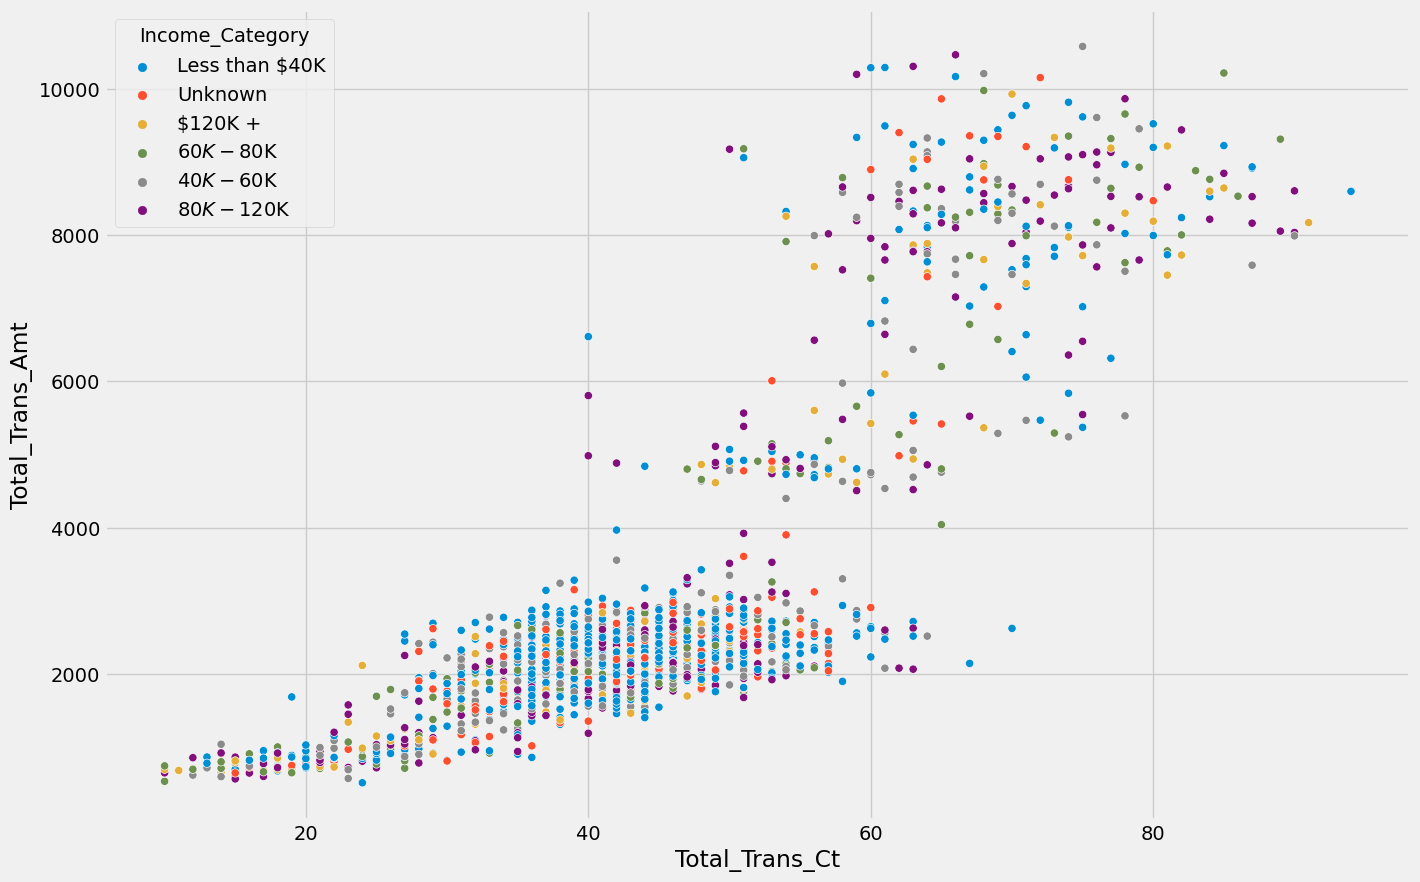

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 10))


sns.scatterplot(data=df.loc[df.Attrition_Flag == 1], x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Income_Category',)# palette=['#54BAB9', '#50BAB9', '#A4BAB9', '#44CAB9', '#B4AAB9', '#D4BAD9', '#E9DAC1'])

In [31]:
df_large_amount = df.loc[df.Total_Trans_Amt > 4800].loc[df.Total_Trans_Ct < 80].groupby("Income_Category").agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

df_large_amount["Churn_rate"] = df_large_amount['num_churn']/df_large_amount["num_user"]
df_large_amount

,num_user,num_churn,Churn_rate
Income_Category,,,
$120K +,50,26,0.520000
$40K - $60K,106,37,0.349057
$60K - $80K,76,36,0.473684
$80K - $120K,107,66,0.616822
Less than $40K,280,65,0.232143
Unknown,79,19,0.240506


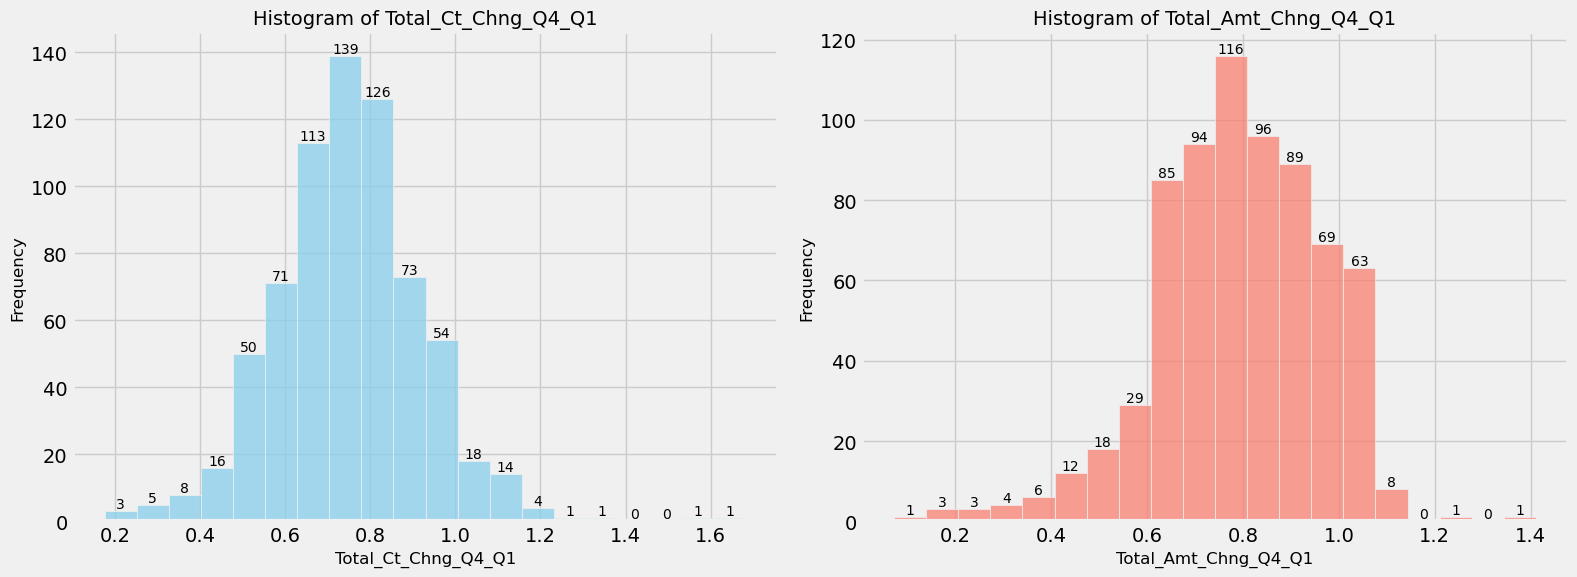

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame
filtered_df = df.loc[(df.Total_Trans_Amt > 4800) & (df.Total_Trans_Ct < 80)]

# Create a figure with two subplots
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

# Plot histogram for Total_Ct_Chng_Q4_Q1
sns.histplot(filtered_df['Total_Ct_Chng_Q4_Q1'], bins=20, kde=False, color='skyblue', ax=ax[0])
ax[0].set_title('Histogram of Total_Ct_Chng_Q4_Q1', fontsize=14)
ax[0].set_xlabel('Total_Ct_Chng_Q4_Q1', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)

# Add data labels to the Total_Ct_Chng_Q4_Q1 histogram
for p in ax[0].patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = height
    ax[0].text(x, y, f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

# Plot histogram for Total_Amt_Chng_Q4_Q1
sns.histplot(filtered_df['Total_Amt_Chng_Q4_Q1'], bins=20, kde=False, color='salmon', ax=ax[1])
ax[1].set_title('Histogram of Total_Amt_Chng_Q4_Q1', fontsize=14)
ax[1].set_xlabel('Total_Amt_Chng_Q4_Q1', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)

# Add data labels to the Total_Amt_Chng_Q4_Q1 histogram
for p in ax[1].patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = height
    ax[1].text(x, y, f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Total_Trans_Amt'>

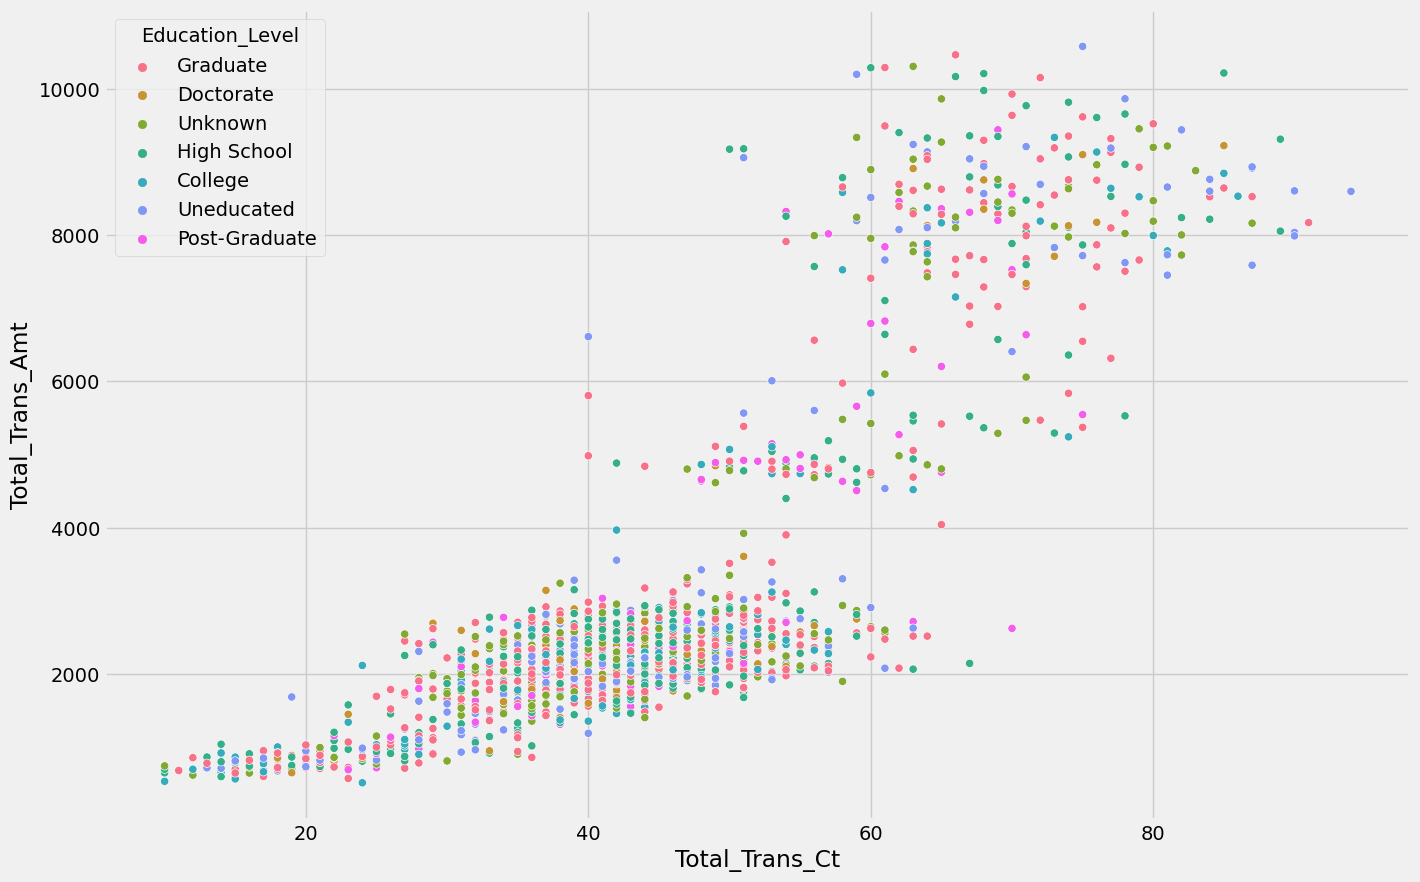

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 10))


sns.scatterplot(data=df.loc[df.Attrition_Flag == 1], x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Education_Level',)# palette=['#54BAB9', '#50BAB9', '#A4BAB9', '#44CAB9', '#B4AAB9', '#D4BAD9', '#E9DAC1'])

In [34]:
df_large_amount = df.loc[df.Total_Trans_Amt > 4800].loc[df.Total_Trans_Ct < 80].groupby("Education_Level").agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

df_large_amount["Churn_rate"] = df_large_amount['num_churn']/df_large_amount["num_user"]
df_large_amount

,num_user,num_churn,Churn_rate
Education_Level,,,
College,65,18,0.276923
Doctorate,29,10,0.344828
Graduate,227,78,0.343612
High School,137,49,0.357664
Post-Graduate,42,24,0.571429
Uneducated,95,29,0.305263
Unknown,103,41,0.398058


<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Total_Trans_Amt'>

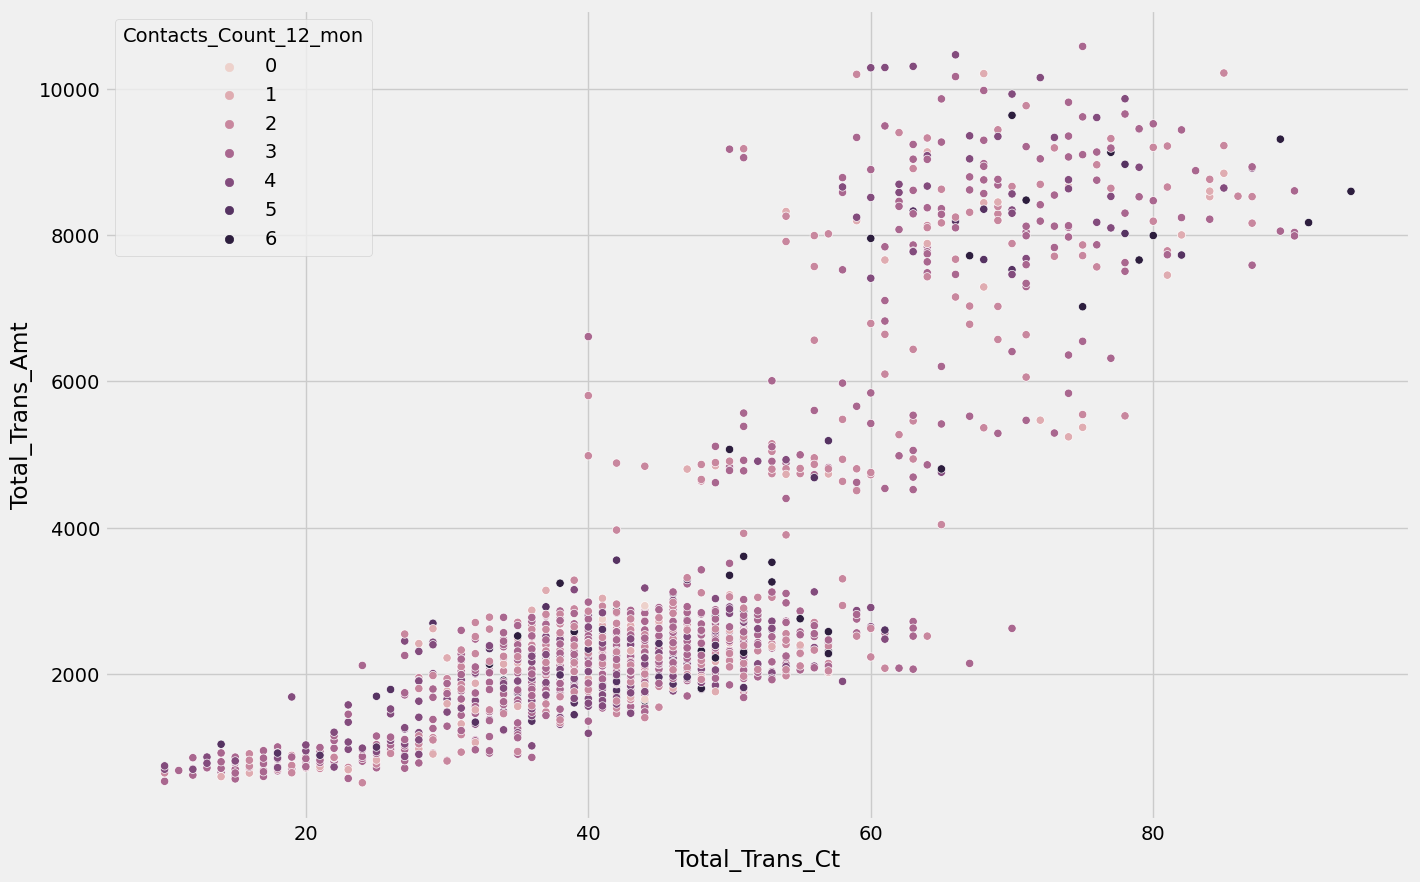

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 10))


sns.scatterplot(data=df.loc[df.Attrition_Flag == 1], x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Contacts_Count_12_mon',)# palette=['#54BAB9', '#50BAB9', '#A4BAB9', '#44CAB9', '#B4AAB9', '#D4BAD9', '#E9DAC1'])

In [36]:
df_large_amount = df.loc[(df.Total_Trans_Amt > 4800) & (df.Total_Trans_Ct < 80)].groupby("Contacts_Count_12_mon").agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
)

df_large_amount["Churn_rate"] = df_large_amount['num_churn']/df_large_amount["num_user"]
df_large_amount

,num_user,num_churn,Churn_rate
Contacts_Count_12_mon,,,
0,18,0,0.000000
1,127,17,0.133858
2,205,72,0.351220
3,266,108,0.406015
4,64,35,0.546875
5,9,8,0.888889
6,9,9,1.000000


In [37]:
df_large_amount_income_education = df.groupby(["Income_Category", "Education_Level"]).agg(
    num_user=("CLIENTNUM", "count"),
    num_churn=("Attrition_Flag", "sum")
).reset_index()

df_large_amount_income_education["Churn_rate"] = df_large_amount_income_education['num_churn']/df_large_amount_income_education["num_user"]
df_large_amount_income_education

,Income_Category,Education_Level,num_user,num_churn,Churn_rate
0,$120K +,College,70,12,0.171429
1,$120K +,Doctorate,37,8,0.216216
2,$120K +,Graduate,204,32,0.156863
3,$120K +,High School,147,28,0.190476
4,$120K +,Post-Graduate,30,4,0.133333
5,$120K +,Uneducated,119,23,0.193277
6,$120K +,Unknown,120,19,0.158333
7,$40K - $60K,College,183,24,0.131148
8,$40K - $60K,Doctorate,70,11,0.157143
9,$40K - $60K,Graduate,553,77,0.139241


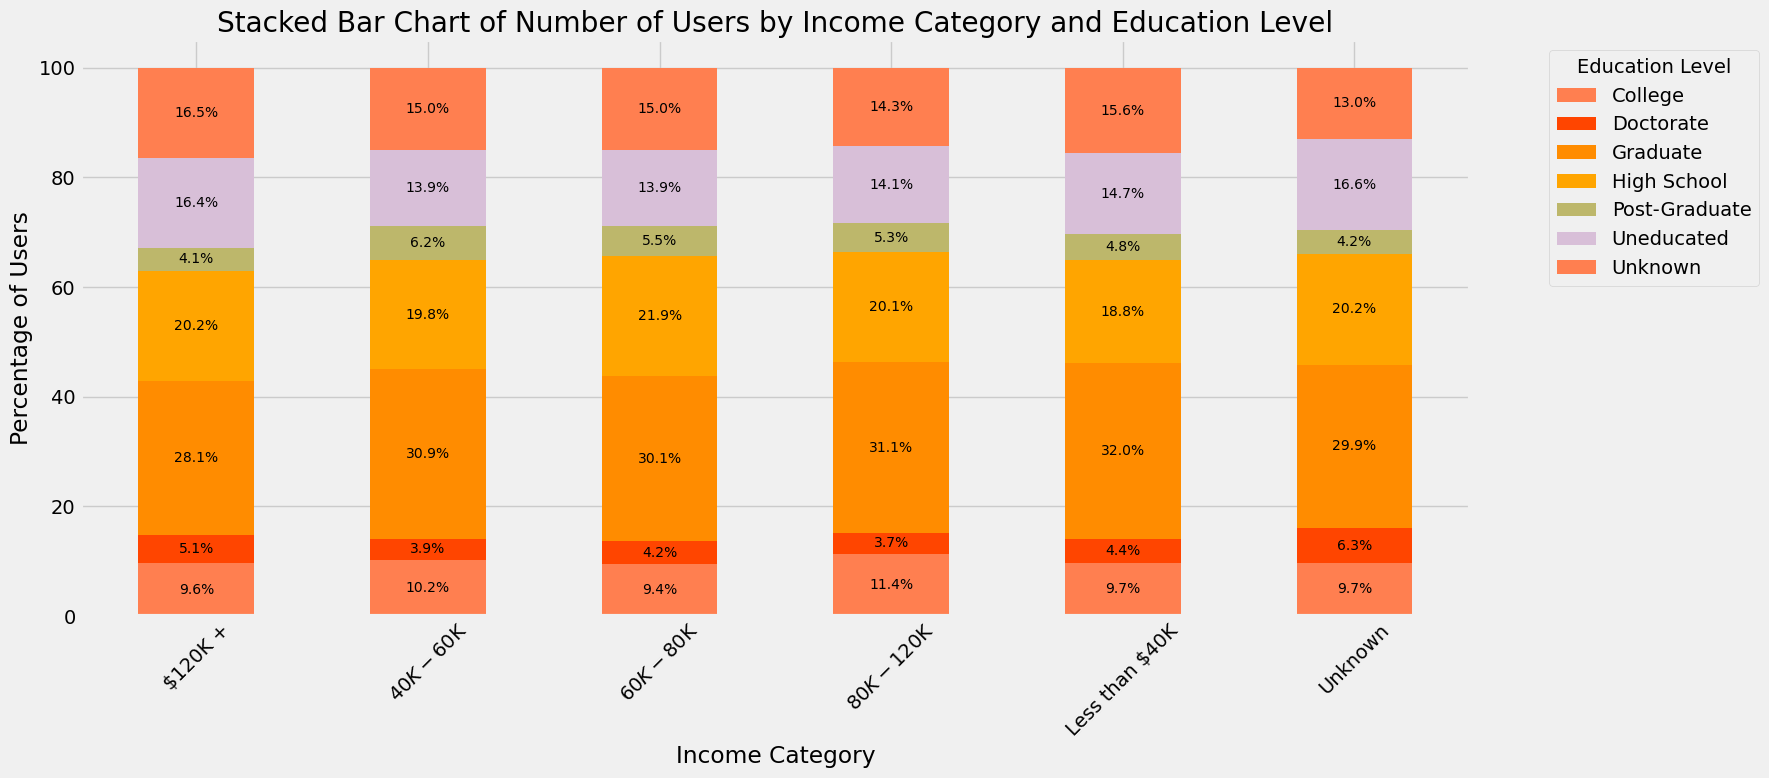

In [38]:
import matplotlib.pyplot as plt

# Define a custom color palette
colors = ['#FF7F50', '#FF4500', '#FF8C00', '#FFA500', '#BDB76B', '#D8BFD8']

# Pivot DataFrame
df_pivot = df_large_amount_income_education.pivot(index='Income_Category', columns='Education_Level', values='num_user')
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with custom colors
ax = df_percent.plot(kind='bar', stacked=True, figsize=(18, 8), color=colors)

# Add labels and title
plt.xlabel('Income Category')
plt.ylabel('Percentage of Users')
plt.title('Stacked Bar Chart of Number of Users by Income Category and Education Level')
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add data labels to each bar
for c in ax.containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=10, color='black')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
for cols in ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']:
    min_value = df[cols].min()
    max_value = df[cols].max()
    df[cols + "_nomarlize"] = (max_value - df[cols])/(max_value - min_value)
    
for cols in ['Months_Inactive_12_mon']:
    min_value = df[cols].min()
    max_value = df[cols].max()
    df[cols + "_nomarlize"] = (max_value - df[cols])/(max_value - min_value)
    
    
for cols in ['Total_Trans_Amt', 'Total_Trans_Ct']:
    df[cols + "_nomarlize"] = pd.qcut(df[cols], 10, labels=False)
    

df["Recency"] = (df["Months_Inactive_12_mon_nomarlize"] * 3)
df["Frequency"] = (df["Total_Trans_Ct_nomarlize"])
df["Monetary"] = (df["Total_Trans_Amt_nomarlize"])

df["RFM"] = df["Recency"] + df["Frequency"] + df["Monetary"] 

In [40]:
df


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Income_Category_Numerical,Total_Amt_Chng_Q4_Q1_nomarlize,Total_Ct_Chng_Q4_Q1_nomarlize,Months_Inactive_12_mon_nomarlize,Total_Trans_Amt_nomarlize,Total_Trans_Ct_nomarlize,Recency,Frequency,Monetary,RFM
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,70.0,0.607006,0.562466,0.833333,0,2,2.5,2,0,4.5
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,40.0,0.546364,0.000000,0.833333,0,0,2.5,0,0,2.5
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,100.0,0.236385,0.371836,0.833333,1,0,2.5,0,1,3.5
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,40.0,0.586400,0.371836,0.333333,0,0,1.0,0,0,1.0
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,70.0,0.359729,0.326871,0.833333,0,0,2.5,0,0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,0,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,NaN,0.793053,0.769251,0.666667,9,9,2.0,9,9,20.0
10123,710638233,1,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,NaN,0.763321,0.816101,0.666667,9,5,2.0,5,9,16.0
10124,716506083,1,44,F,1,High School,Married,Less than $40K,Blue,36,...,40.0,0.758905,0.779752,0.500000,9,3,1.5,3,9,13.5
10125,717406983,1,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,NaN,0.842508,0.805600,0.500000,9,4,1.5,4,9,14.5


In [41]:
df["Months_Inactive_12_mon"].value_counts()
df["Total_Trans_Ct_nomarlize"].value_counts()
df[["Recency", "Frequency", "Monetary",  "RFM", "Attrition_Flag"]]


,Recency,Frequency,Monetary,RFM,Attrition_Flag
0,2.5,2,0,4.5,0
1,2.5,0,0,2.5,0
2,2.5,0,1,3.5,0
3,1.0,0,0,1.0,0
4,2.5,0,0,2.5,0
...,...,...,...,...,...
10122,2.0,9,9,20.0,0
10123,2.0,5,9,16.0,1
10124,1.5,3,9,13.5,1
10125,1.5,4,9,14.5,1


<AxesSubplot:xlabel='RFM', ylabel='Density'>

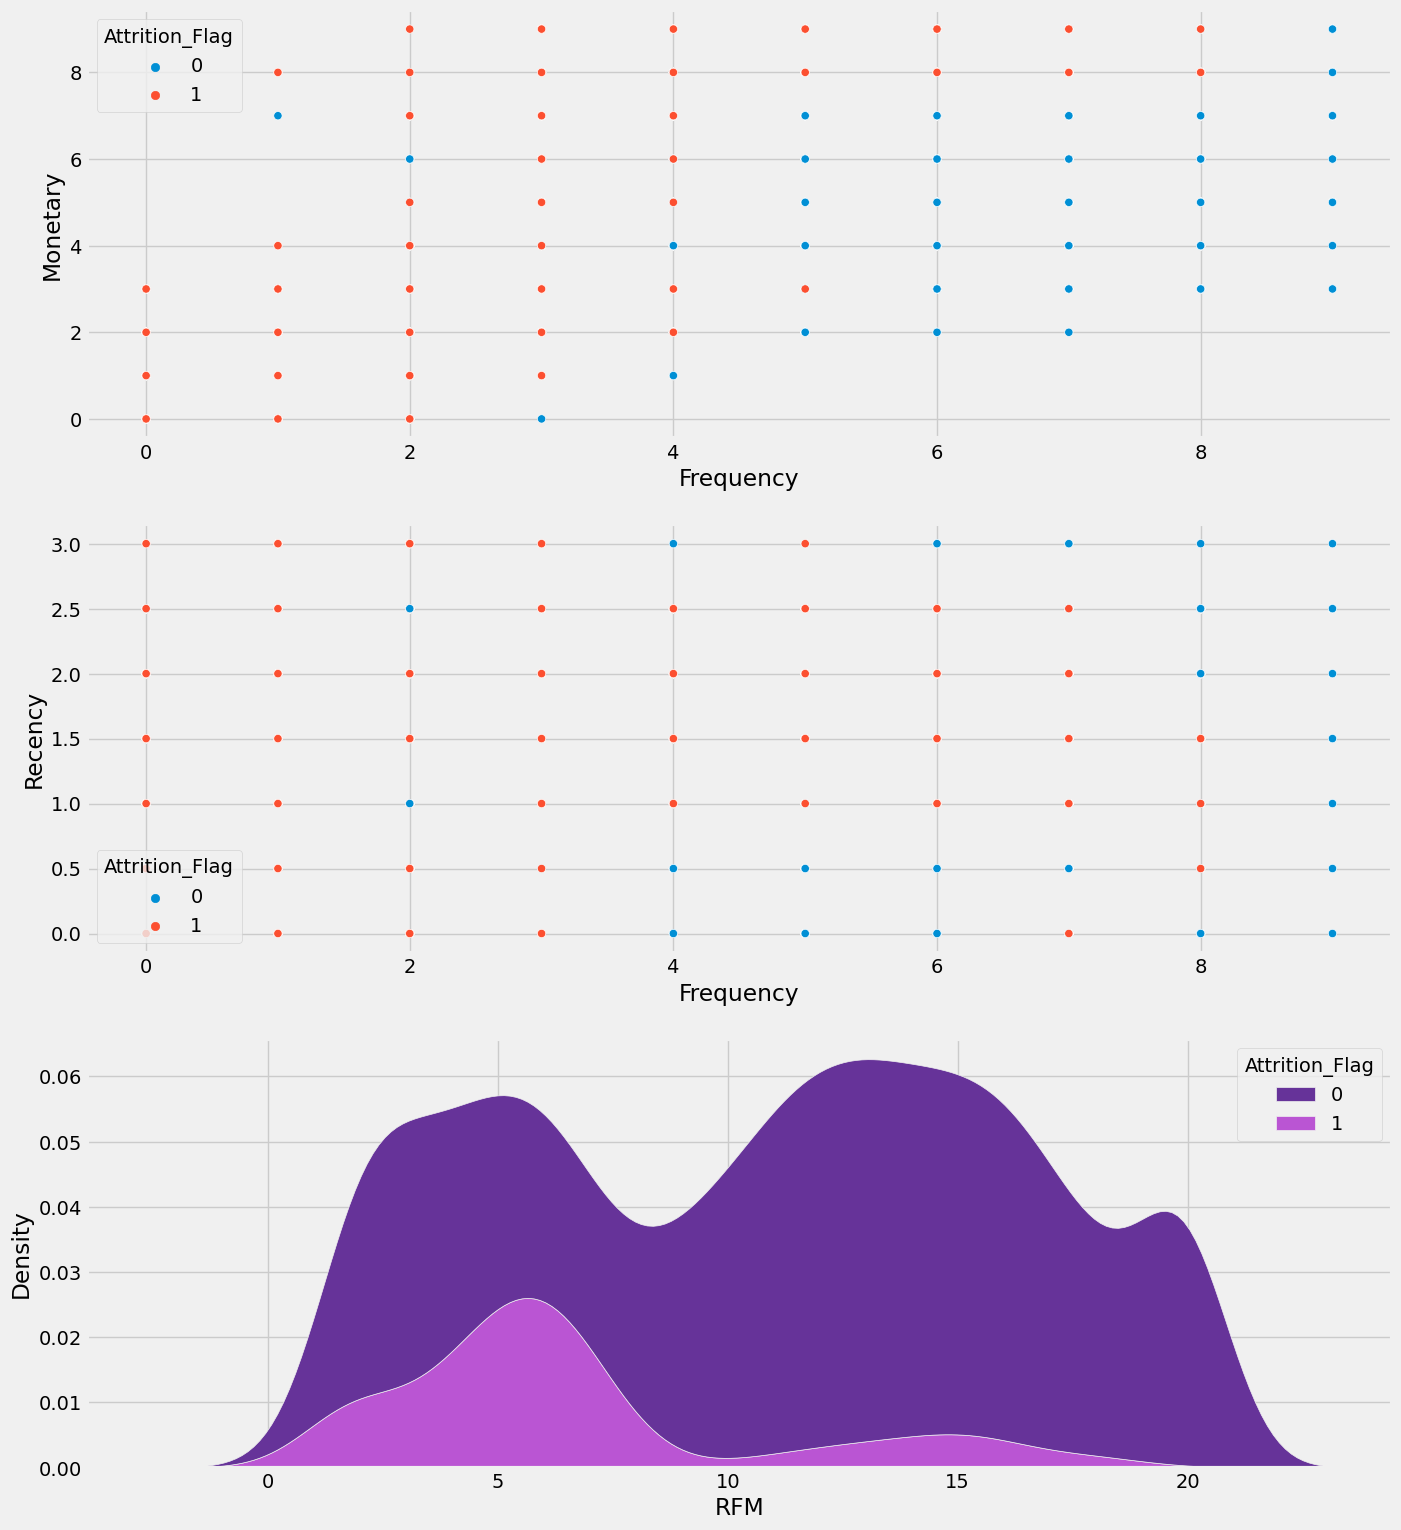

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6*3))

sns.scatterplot(data=df, x='Frequency', y='Monetary', hue="Attrition_Flag", ax=ax[0])
sns.scatterplot(data=df, x='Frequency', y='Recency', hue="Attrition_Flag", ax=ax[1])

# sns.scatterplot(data=df, x='Recency', y='Monetary', hue="Attrition_Flag", ax=ax[2])
sns.kdeplot(df["RFM"], fill=True, alpha=1, hue = df['Attrition_Flag'], 
                palette=('#663399', '#BA55D3'), multiple='stack', ax=ax[2])

In [43]:
# Ensure necessary columns are converted to integer type
df["Recency"] = df["Recency"].astype(int)
df["Frequency"] = df["Frequency"].astype(int)
df["Monetary"] = df["Monetary"].astype(int)
df["RFM"] = df["RFM"].astype(int)

# Group by RFM score and calculate the number of users and churn rate
df_rfm = df.groupby("RFM").agg(
    num_user=("CLIENTNUM", "count"),
    Churn_rate=('Attrition_Flag', 'mean')
).reset_index()

# Display the resulting DataFrame
print(df_rfm)


    RFM  num_user  Churn_rate
0     0        13    0.307692
1     1       303    0.336634
2     2       611    0.209493
3     3       517    0.191489
4     4       560    0.373214
5     5       628    0.476115
6     6       547    0.522852
7     7       403    0.369727
8     8       326    0.101227
9     9       402    0.019900
10   10       491    0.026477
11   11       607    0.044481
12   12       616    0.055195
13   13       647    0.068006
14   14       635    0.085039
15   15       611    0.093290
16   16       560    0.064286
17   17       434    0.050691
18   18       320    0.059375
19   19       411    0.007299
20   20       485    0.002062


In [44]:
# Ensure necessary columns are converted to integer type
df["Recency"] = df["Recency"].astype(int)
df["Frequency"] = df["Frequency"].astype(int)
df["Monetary"] = df["Monetary"].astype(int)
df["RFM"] = df["RFM"].astype(int)

# Group by RFM score and calculate the number of users and churn rate
df_rfm = df.groupby("RFM").agg(
    num_user=("CLIENTNUM", "count"),
    Churn_rate=('Attrition_Flag', 'mean')
).reset_index()

# Display the resulting DataFrame
print(df_rfm)


    RFM  num_user  Churn_rate
0     0        13    0.307692
1     1       303    0.336634
2     2       611    0.209493
3     3       517    0.191489
4     4       560    0.373214
5     5       628    0.476115
6     6       547    0.522852
7     7       403    0.369727
8     8       326    0.101227
9     9       402    0.019900
10   10       491    0.026477
11   11       607    0.044481
12   12       616    0.055195
13   13       647    0.068006
14   14       635    0.085039
15   15       611    0.093290
16   16       560    0.064286
17   17       434    0.050691
18   18       320    0.059375
19   19       411    0.007299
20   20       485    0.002062


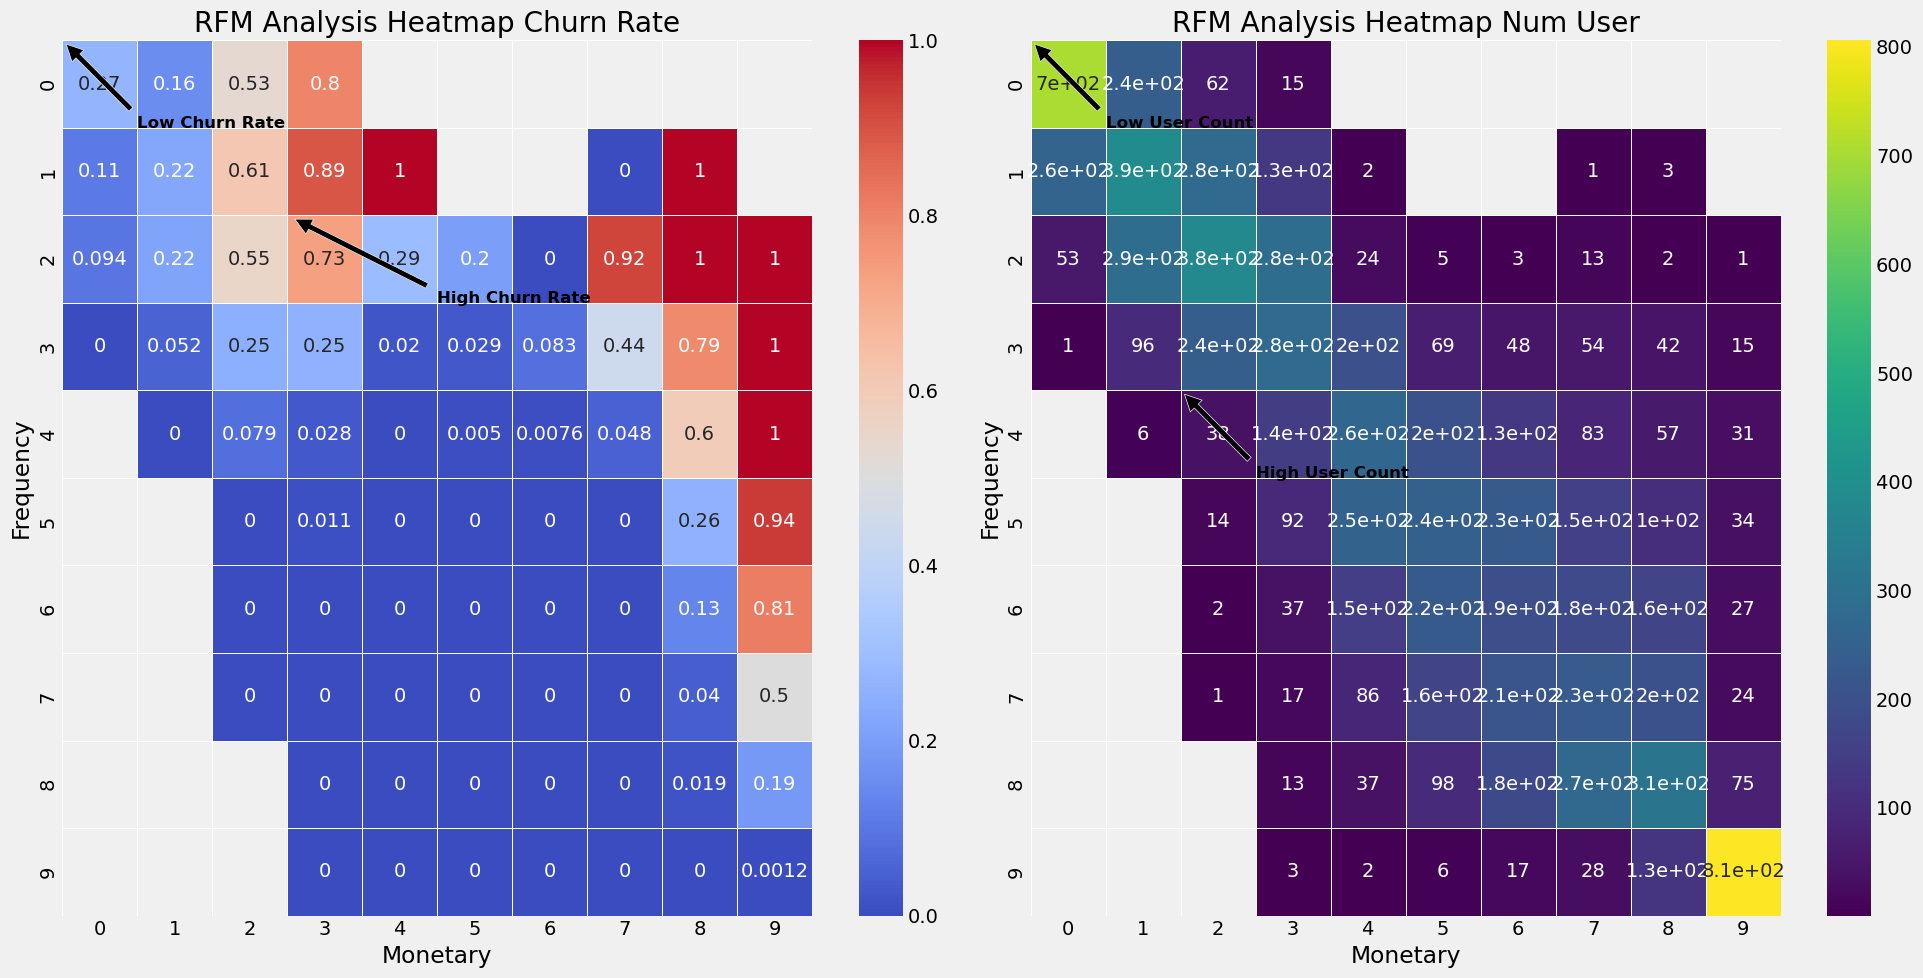

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Frequency and Monetary, and calculate num_user and Churn_rate
df_rfm_visual = df.groupby(["Frequency", "Monetary"]).agg(
    num_user=("CLIENTNUM", "count"),
    Churn_rate=('Attrition_Flag', 'mean')).reset_index()

# Pivot tables for churn rate and number of users
df_rfm_churn_rate = df_rfm_visual.pivot_table(index=['Frequency'], columns=['Monetary'], values=['Churn_rate'])
df_rfm_churn_rate.columns = list(range(0, len(df_rfm_churn_rate.columns)))

df_rfm_num_user = df_rfm_visual.pivot_table(index=['Frequency'], columns=['Monetary'], values=['num_user'])
df_rfm_num_user.columns = list(range(0, len(df_rfm_num_user.columns)))

# Plot the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(df_rfm_churn_rate, annot=True, cmap="coolwarm", cbar=True, linewidths=.5, ax=ax[0])
sns.heatmap(df_rfm_num_user, annot=True, cmap="viridis", cbar=True, linewidths=.5, ax=ax[1])

# Titles and labels
ax[0].set_title('RFM Analysis Heatmap Churn Rate')
ax[0].set_xlabel('Monetary')
ax[0].set_ylabel('Frequency')

ax[1].set_title('RFM Analysis Heatmap Num User')
ax[1].set_xlabel('Monetary')
ax[1].set_ylabel('Frequency')

# Key points for Churn Rate
ax[0].annotate('High Churn Rate', xy=(3, 2), xytext=(5, 3),
               arrowprops=dict(facecolor='black', shrink=0.05),
               fontsize=12, color='black', weight='bold')
ax[0].annotate('Low Churn Rate', xy=(0, 0), xytext=(1, 1),
               arrowprops=dict(facecolor='black', shrink=0.05),
               fontsize=12, color='black', weight='bold')

# Key points for Number of Users
ax[1].annotate('High User Count', xy=(2, 4), xytext=(3, 5),
               arrowprops=dict(facecolor='black', shrink=0.05),
               fontsize=12, color='black', weight='bold')
ax[1].annotate('Low User Count', xy=(0, 0), xytext=(1, 1),
               arrowprops=dict(facecolor='black', shrink=0.05),
               fontsize=12, color='black', weight='bold')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             Churn_rate   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     18.13
Date:                Wed, 07 Aug 2024   Prob (F-statistic):            0.00277
Time:                        02:55:09   Log-Likelihood:                 9.9075
No. Observations:                  10   AIC:                            -15.82
Df Residuals:                       8   BIC:                            -15.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3686      0.059      6.243      0.0

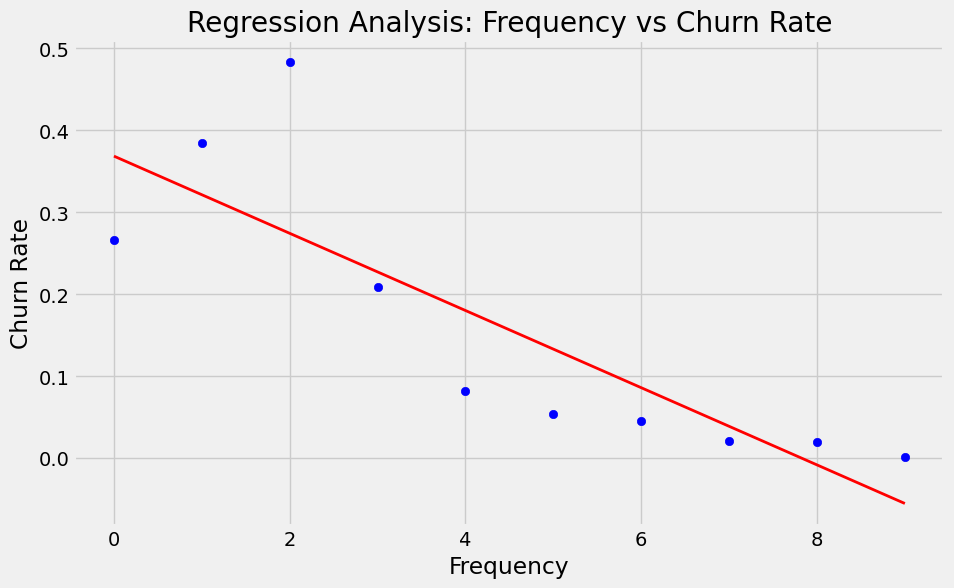

In [46]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Group by Frequency and calculate Churn_rate
df_rfm_visual = df.groupby(["Frequency"]).agg(
    Churn_rate=('Attrition_Flag', 'mean')).reset_index()

# Define the independent variable (Frequency) and the dependent variable (Churn_rate)
X = df_rfm_visual['Frequency']
y = df_rfm_visual['Churn_rate']

# Add a constant to the independent variable (required for statsmodels)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(df_rfm_visual['Frequency'], df_rfm_visual['Churn_rate'], color='blue')
plt.plot(df_rfm_visual['Frequency'], model.predict(X), color='red', linewidth=2)
plt.xlabel('Frequency')
plt.ylabel('Churn Rate')
plt.title('Regression Analysis: Frequency vs Churn Rate')
plt.grid(True)
plt.show()
